In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sqlalchemy import create_engine
import MySQLdb
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

In [2]:
# DB Connection
myvars = {}
with open("../risaac-mysql-password") as myfile:
    for line in myfile:
        name, var = line.partition(":")[::2]
        myvars[name.strip()] = var.strip()

In [3]:
myvars['DB databasename'] = 'I501saptpurkFall22grp_06_db'

In [4]:
conn = MySQLdb.connect(host="localhost", user=myvars['DB username'], passwd=myvars['DB password'], db=myvars['DB databasename'])
cursor = conn.cursor()

In [5]:
df = pd.read_sql('select * from P_DEMO_HUQ_HIQ', conn)

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [6]:
df.head(10)

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,DMDBORN4,DMDYRUSZ,DMDEDUC2,DMDMARTZ,RIDEXPRG,SIALANG,SIAPROXY,SIAINTRP,INDFMPIR,INDFMPIR_imputed,HUQ010,HUQ030,HUQ051,HUQ071,HUQ090,HIQ011,HIQ032A,HIQ032B,HIQ032C,HIQ032D,HIQ032E,HIQ032H,HIQ032I,HIQ270,HIQ210
0,109263,66,2,0,2,24,5,6,1,5,6,4,4,1,1,2,4.66,4.66,1.0,1.0,1.0,2.0,2.0,1.0,1.0,0,0,0,0,0,0,1.0,2.0
1,109264,66,2,1,13,156,1,1,1,5,6,4,4,1,1,2,0.83,0.83,2.0,1.0,0.0,2.0,1.0,1.0,2.0,0,0,0,0,1,0,1.0,2.0
2,109265,66,2,0,2,24,3,3,1,5,6,4,4,1,1,2,3.06,3.06,1.0,1.0,2.0,2.0,2.0,1.0,1.0,0,0,1,0,0,0,1.0,2.0
3,109266,66,2,1,29,348,5,6,2,2,5,3,2,1,2,2,5.00,5.00,3.0,1.0,1.0,2.0,2.0,1.0,1.0,0,0,0,0,0,0,1.0,2.0
4,109267,66,1,1,21,252,2,2,2,3,4,3,3,1,2,2,5.00,5.00,1.0,2.0,1.0,2.0,2.0,1.0,1.0,0,0,0,0,0,0,1.0,2.0
5,109268,66,1,1,18,216,3,3,1,5,6,4,4,1,2,2,1.66,1.66,3.0,2.0,0.0,2.0,2.0,1.0,1.0,0,0,0,0,0,0,1.0,2.0
6,109269,66,2,0,2,24,2,2,1,5,6,4,4,1,1,2,0.96,0.96,1.0,1.0,4.0,2.0,2.0,1.0,2.0,0,0,0,1,0,0,2.0,1.0
7,109270,66,2,1,11,132,4,4,1,5,6,4,4,1,1,2,1.88,1.88,2.0,1.0,4.0,2.0,2.0,1.0,2.0,0,0,1,0,0,0,1.0,2.0
8,109271,66,2,0,49,588,3,3,1,5,2,3,4,1,2,2,NaN,0.00,4.0,1.0,2.0,2.0,2.0,1.0,2.0,1,0,1,0,0,0,1.0,2.0
9,109272,66,2,0,0,3,1,1,1,5,6,4,4,1,1,2,0.73,0.73,1.0,1.0,2.0,1.0,2.0,1.0,2.0,0,0,0,0,1,0,1.0,2.0


In [7]:
df.isna().sum()

SEQN                   0
SDDSRVYR               0
RIDSTATR               0
RIAGENDR               0
RIDAGEYR               0
RIDAGEMN               0
RIDRETH1               0
RIDRETH3               0
DMDBORN4               0
DMDYRUSZ               0
DMDEDUC2               0
DMDMARTZ               0
RIDEXPRG               0
SIALANG                0
SIAPROXY               0
SIAINTRP               0
INDFMPIR            2127
INDFMPIR_imputed       0
HUQ010                 9
HUQ030                 4
HUQ051                39
HUQ071                 3
HUQ090                 6
HIQ011                33
HIQ032A              124
HIQ032B                0
HIQ032C                0
HIQ032D                0
HIQ032E                0
HIQ032H                0
HIQ032I                0
HIQ270               191
HIQ210                26
dtype: int64

In [8]:
# remove INDFMPIR and replace with INDFMPIR_imputed
df = df.drop("INDFMPIR", axis = 1)

In [9]:
df = df[~df.isna().any(axis = 1)]

In [10]:
df = df.rename(columns = {"INDFMPIR_imputed":"INDFMPIR"})

In [11]:
# copy dataframe
df_temp = df.copy()

In [12]:
df.columns

Index(['SEQN', 'SDDSRVYR', 'RIDSTATR', 'RIAGENDR', 'RIDAGEYR', 'RIDAGEMN',
       'RIDRETH1', 'RIDRETH3', 'DMDBORN4', 'DMDYRUSZ', 'DMDEDUC2', 'DMDMARTZ',
       'RIDEXPRG', 'SIALANG', 'SIAPROXY', 'SIAINTRP', 'INDFMPIR', 'HUQ010',
       'HUQ030', 'HUQ051', 'HUQ071', 'HUQ090', 'HIQ011', 'HIQ032A', 'HIQ032B',
       'HIQ032C', 'HIQ032D', 'HIQ032E', 'HIQ032H', 'HIQ032I', 'HIQ270',
       'HIQ210'],
      dtype='object')

In [13]:
# segragating features into nominal, ordinal and numeric
nominal_cols = [
    "RIAGENDR"
    ,"RIDRETH3"
    ,"DMDBORN4"
    ,"DMDMARTZ"
    ,"RIDEXPRG"
    ,"SIALANG"
    ,"SIAPROXY"
    ,"SIAINTRP"
    ,"HUQ030"
    ,"HUQ071"
    ,"HUQ090"
    ,"HIQ011"
    ,'HIQ032A'
    ,'HIQ032B'
    ,'HIQ032C'
    ,'HIQ032D'
    ,'HIQ032E'
    ,'HIQ032H'
    ,'HIQ032I'
    ,'HIQ270'
    ,'HIQ210'
]

ordinal_cols = [
    "DMDYRUSZ"
    ,"DMDEDUC2"
    ,"HUQ010"
    ,"HUQ051"
]

numeric_cols = [
    "RIDAGEYR"
    ,"RIDAGEMN"
    ,"INDFMPIR"
]

We will use K Prototypes algorithm since most features are categorical in nature

In [14]:
# check for normality before performing standardization
# if normality is violated we use MinMaxScaler
for col in numeric_cols:
    print(scipy.stats.normaltest(df[col]))

NormaltestResult(statistic=29670.08043847679, pvalue=0.0)
NormaltestResult(statistic=30221.949751948607, pvalue=0.0)
NormaltestResult(statistic=16128.044939874497, pvalue=0.0)


In [15]:
df_temp[numeric_cols + ordinal_cols] = MinMaxScaler().fit_transform(df_temp[numeric_cols + ordinal_cols])
df_temp.head()

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,DMDBORN4,DMDYRUSZ,DMDEDUC2,DMDMARTZ,RIDEXPRG,SIALANG,SIAPROXY,SIAINTRP,INDFMPIR,HUQ010,HUQ030,HUQ051,HUQ071,HUQ090,HIQ011,HIQ032A,HIQ032B,HIQ032C,HIQ032D,HIQ032E,HIQ032H,HIQ032I,HIQ270,HIQ210
0,109263,66,2,0,0.0250,0.0250,5,6,1,1.00,1.0,4,4,1,1,2,0.932,0.00,1.0,0.125,2.0,2.0,1.0,1.0,0,0,0,0,0,0,1.0,2.0
1,109264,66,2,1,0.1625,0.1625,1,1,1,1.00,1.0,4,4,1,1,2,0.166,0.25,1.0,0.000,2.0,1.0,1.0,2.0,0,0,0,0,1,0,1.0,2.0
2,109265,66,2,0,0.0250,0.0250,3,3,1,1.00,1.0,4,4,1,1,2,0.612,0.00,1.0,0.250,2.0,2.0,1.0,1.0,0,0,1,0,0,0,1.0,2.0
3,109266,66,2,1,0.3625,0.3625,5,6,2,0.25,0.8,3,2,1,2,2,1.000,0.50,1.0,0.125,2.0,2.0,1.0,1.0,0,0,0,0,0,0,1.0,2.0
4,109267,66,1,1,0.2625,0.2625,2,2,2,0.50,0.6,3,3,1,2,2,1.000,0.00,2.0,0.125,2.0,2.0,1.0,1.0,0,0,0,0,0,0,1.0,2.0


#### K Prototype Clustering

In [16]:
# get indices for all categorical columns - this is required for kprototype algo
col_idx = []
for col in nominal_cols:
    col_idx.append(df_temp[nominal_cols + ordinal_cols + numeric_cols].columns.get_loc(col))

In [17]:
#Choosing optimal K value
cost = []

for num_clusters in list(range(2,9)):
    kproto = KPrototypes(n_clusters=num_clusters, n_jobs = 4) 
    kproto.fit_predict(df_temp[nominal_cols + ordinal_cols + numeric_cols], categorical=col_idx)
    cost.append(kproto.cost_)
    print(num_clusters, "cost :", kproto.cost_)

2 cost : 13488.825674987167
3 cost : 12191.354074400797
4 cost : 11422.481764092905
5 cost : 10407.046219475265
6 cost : 9891.229052647946
7 cost : 9409.28636839837
8 cost : 9075.235637530339


In [18]:
cost

[13488.825674987167,
 12191.354074400797,
 11422.481764092905,
 10407.046219475265,
 9891.229052647946,
 9409.28636839837,
 9075.235637530339]

<function matplotlib.pyplot.show(close=None, block=None)>

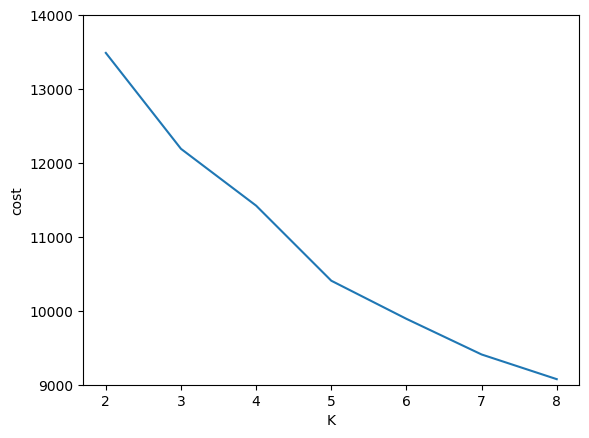

In [19]:
# elbow plot
plt.plot(range(2,9), cost)
plt.xlabel('K')
plt.ylabel('cost')
plt.ylim(9000, 14000)
plt.show

# from the plot we see optimal clusters to be 4

In [20]:
kproto = KPrototypes(n_clusters=3, init='Huang', n_jobs = 4) 
kproto.fit_predict(df_temp[nominal_cols + ordinal_cols + numeric_cols], categorical=col_idx)

array([0, 0, 0, ..., 0, 1, 1], dtype=uint16)

In [21]:
# df["kproto_cluster_label"] = kproto.labels_
df_temp["kproto_cluster_label"] = kproto.labels_

In [22]:
df_temp["kproto_cluster_label"].sort_index().value_counts()

0    6236
1    4566
2    4195
Name: kproto_cluster_label, dtype: int64

/home/students/risaac/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


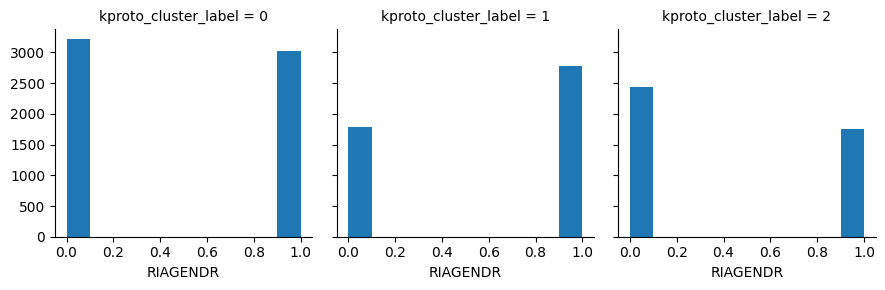

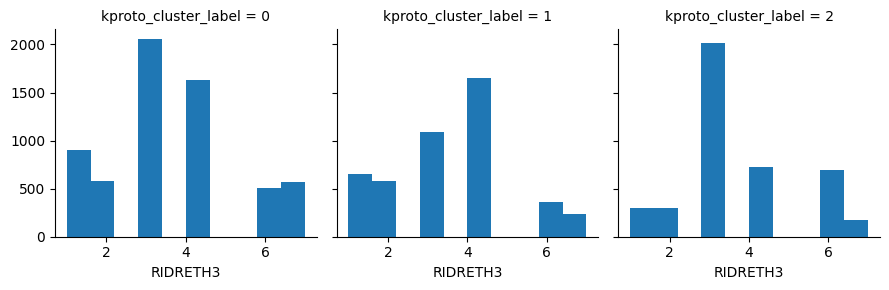

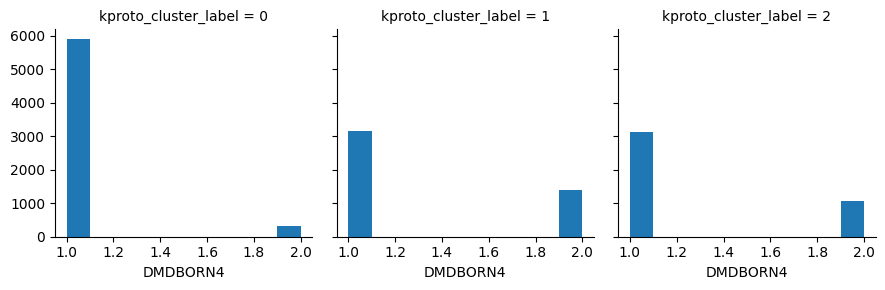

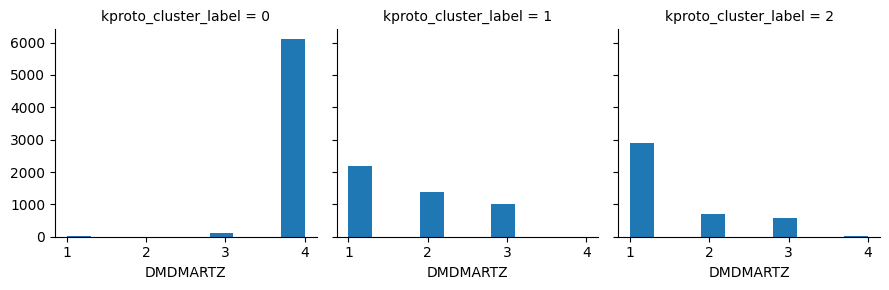

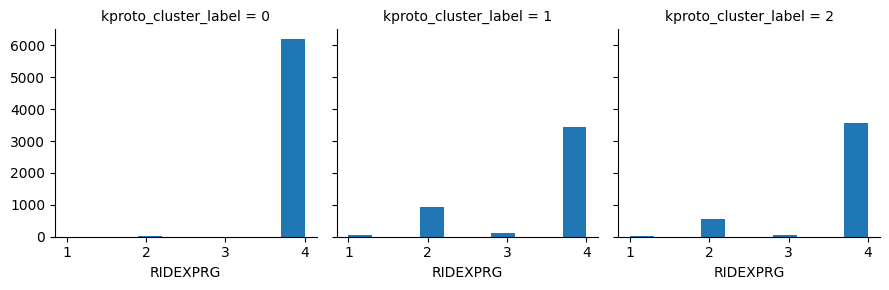

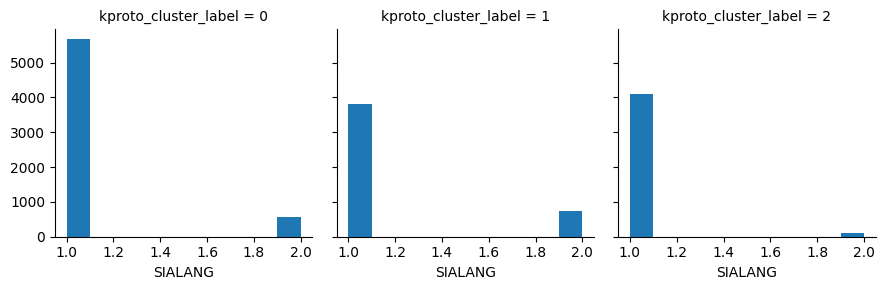

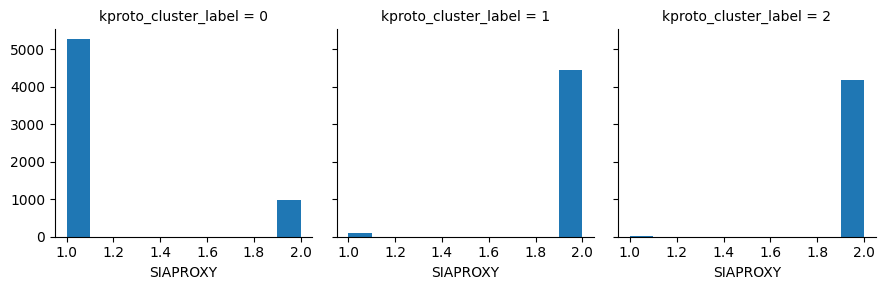

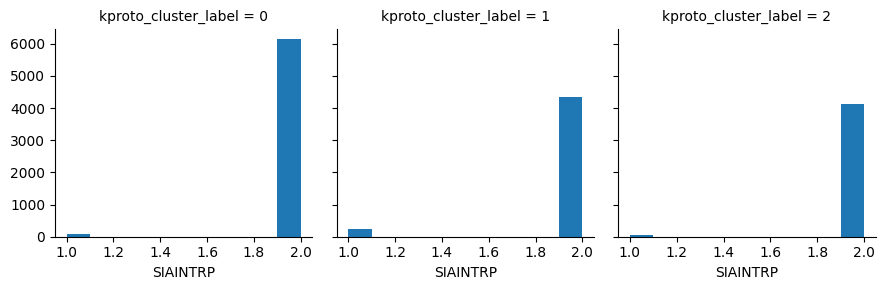

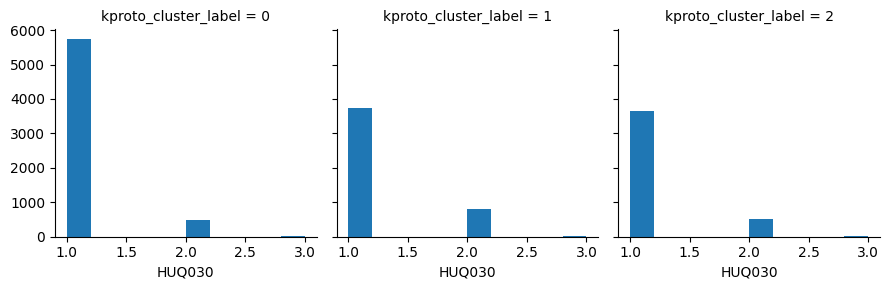

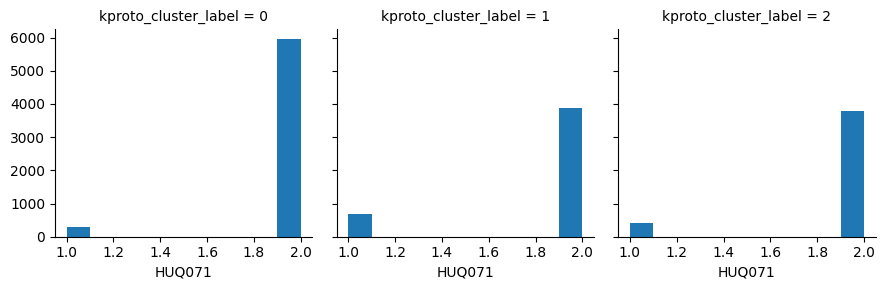

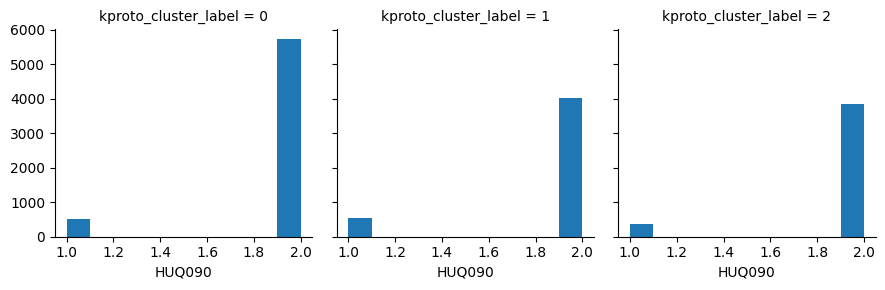

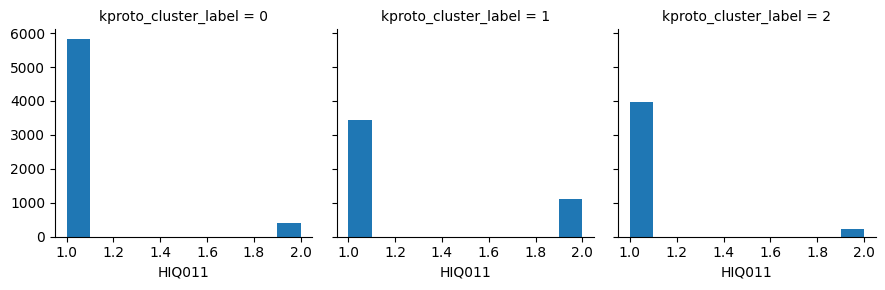

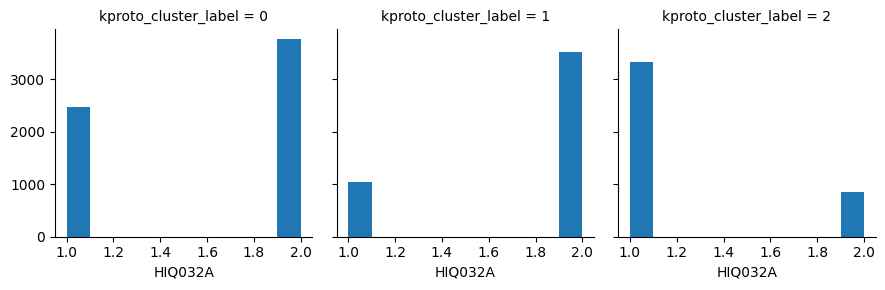

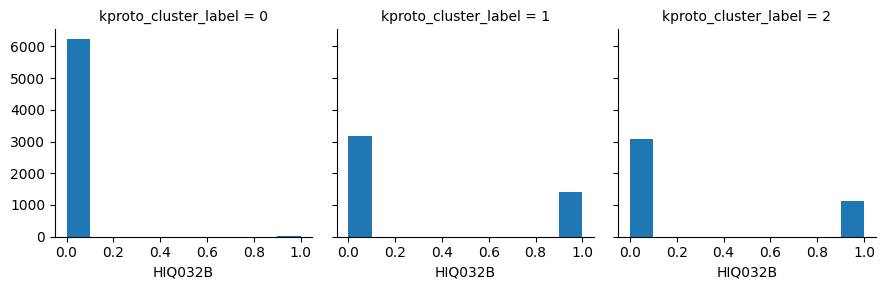

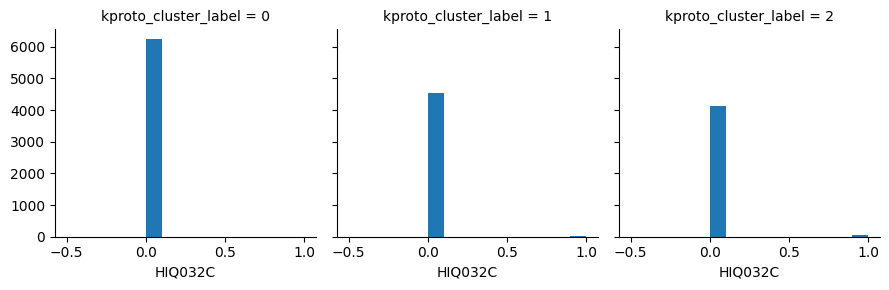

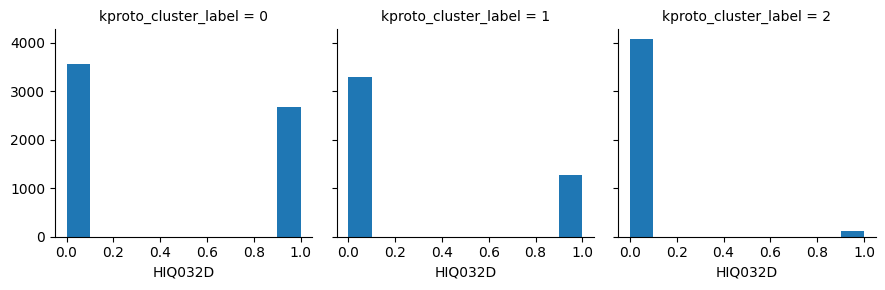

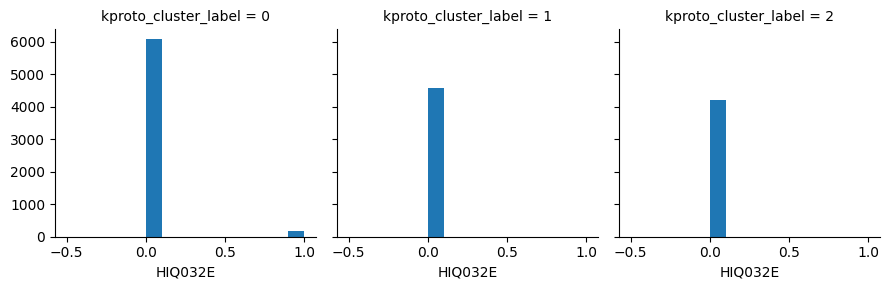

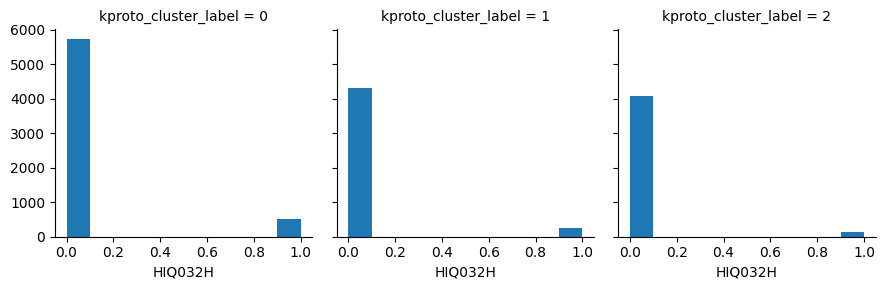

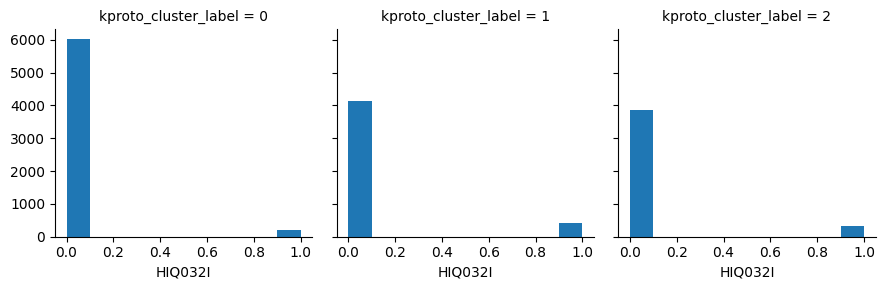

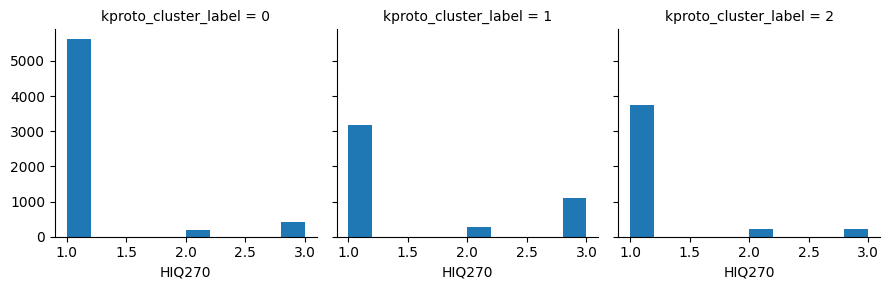

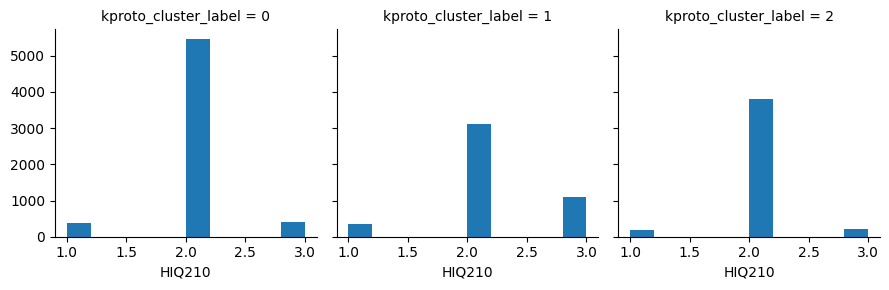

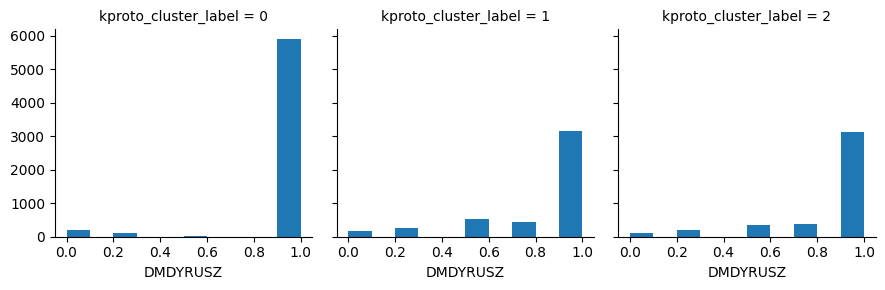

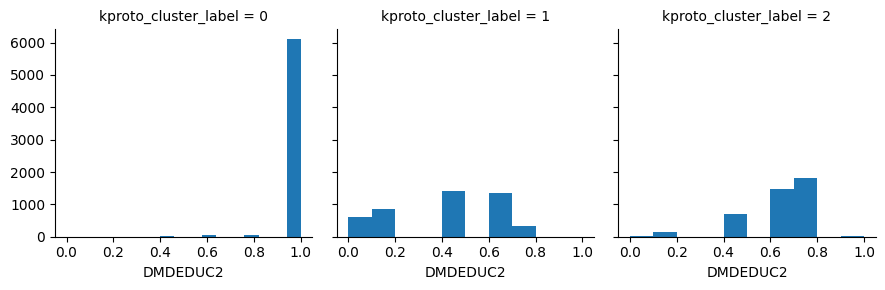

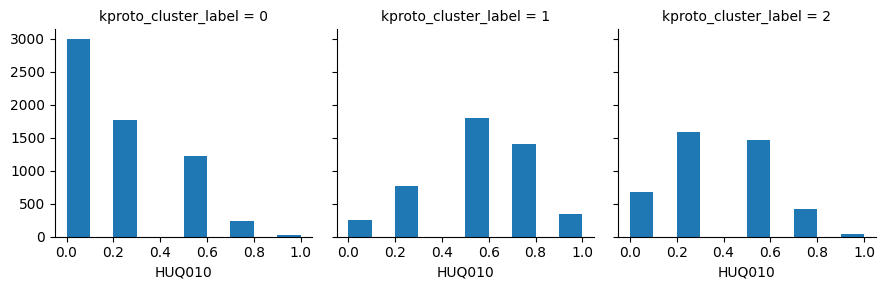

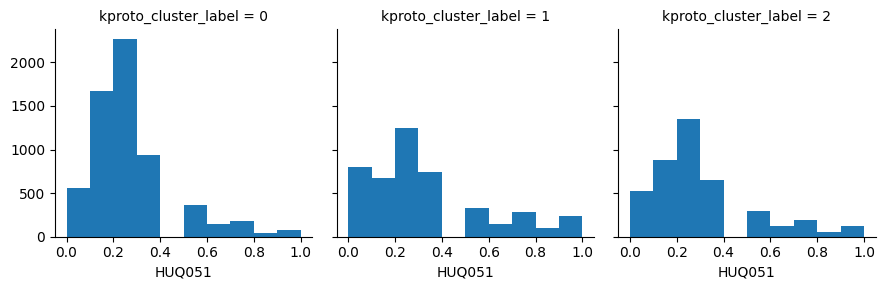

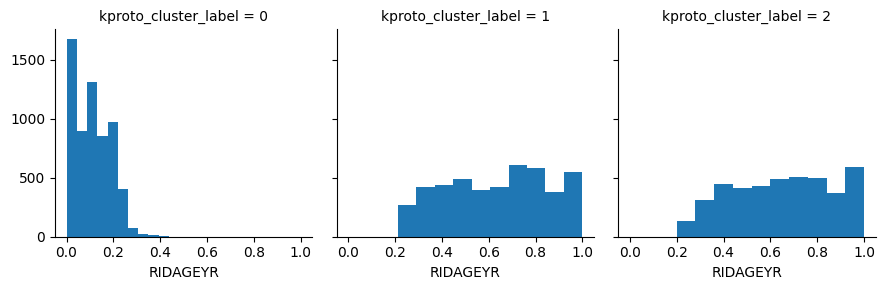

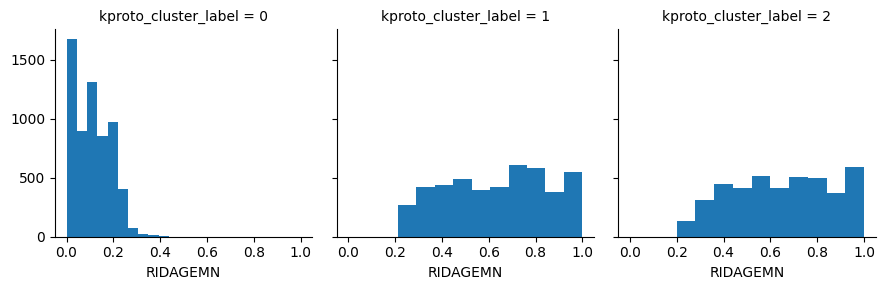

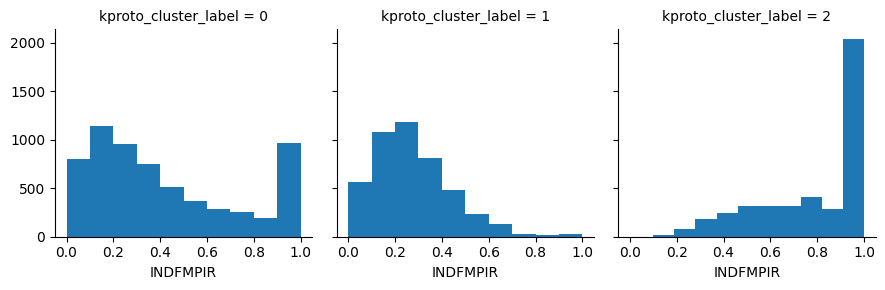

In [23]:
# cluster interpretation
for c in df_temp[nominal_cols + ordinal_cols + numeric_cols]:
    grid= sns.FacetGrid(df_temp[nominal_cols + ordinal_cols + numeric_cols + ['kproto_cluster_label']], col='kproto_cluster_label')
    grid.map(plt.hist, c)

In [24]:
# reference: https://medium.com/more-python-less-problems/principal-component-analysis-and-k-means-clustering-to-visualize-a-high-dimensional-dataset-577b2a7a5fe2

def cluster_visualization(df, columns, labels):
    
    df = df[columns]
    pca = PCA(2)
    pca.fit(df)
    X_PCA = pca.transform(df)
    X_PCA.shape
    print(pca.explained_variance_ratio_)    
    
    x, y = X_PCA[:, 0], X_PCA[:, 1]

    colors = {0: 'red',
              1: 'blue',
              2: 'green'}

    names = {0: 'Cluster 1', 
             1: 'Cluster 2', 
             2: 'Cluster 3'}

    df = pd.DataFrame({'x': x, 'y':y, 'label':labels})
    groups = df.groupby('label')

    fig, ax = plt.subplots(figsize=(20, 13)) 

    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
                color=colors[name],label=names[name], mec='none')
        ax.set_aspect('auto')
        ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
        ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')

    ax.legend()
    ax.set_title("Respondents Segmentation based on their demographics, hospital utilisation & health insurance")
    plt.show()


In [25]:
# covert 1=>0, 2=>1
enc_1_0_cols = ["DMDBORN4"
               ,"SIALANG"
               ,"HIQ032A"]
for col in enc_1_0_cols:
    df[col] = np.where(df[col] == 1, 0, 1)
    
# covert 1=>1, 2=>0
enc_1_0_cols = ["SIAPROXY"
               ,"SIAINTRP"
               ,"HUQ071"
               ,"HUQ090"
               ,"HIQ011"
               ,"HIQ032A"]
for col in enc_1_0_cols:
    df[col] = np.where(df[col] == 1, 1, 0)


In [26]:
one_hot_enc_cols = ["RIDRETH3"
                   ,"RIDRETH1"
                   ,"DMDMARTZ"
                   ,"RIDEXPRG"
                   ,"HUQ030"
                   ,"HIQ270"
                   ,"HIQ210"]

In [27]:
df[["HUQ051","HUQ030","HUQ010","HIQ210","HIQ270"]] = df[["HUQ051","HUQ030","HUQ010","HIQ210","HIQ270"]].astype("Int64")

In [30]:
demo_cols = [
    "RIAGENDR"
    ,"RIDAGEMN"
    ,"RIDRETH1"
    ,"RIDRETH3"
    ,"DMDBORN4"
    ,"DMDMARTZ"
    ,"RIDEXPRG"
    ,"SIALANG"
    ,"SIAPROXY"
    ,"SIAINTRP"
    ,"DMDYRUSZ"
    ,"DMDEDUC2"
    ,"INDFMPIR"
]

huq_cols = ["HUQ010"
           ,"HUQ071"
           ,"HUQ090"
           ,"HUQ051"]

hiq_cols = ["HIQ011"
    ,'HIQ032A'
    ,'HIQ032B'
    ,'HIQ032C'
    ,'HIQ032D'
    ,'HIQ032E'
    ,'HIQ032H'
    ,'HIQ032I'
    ,'HIQ270'
    ,'HIQ210']

In [85]:
df_dum = pd.get_dummies(df[demo_cols + hiq_cols + huq_cols], columns = [col for col in one_hot_enc_cols if col in demo_cols + huq_cols + hiq_cols])

In [86]:
# remove age in years columns since age in months is reflective of it.
numeric_cols = [
#     "RIDAGEYR"
    "RIDAGEMN"
    ,"INDFMPIR"
]

In [87]:
df_dum[numeric_cols + ordinal_cols] = MinMaxScaler().fit_transform(df_dum[numeric_cols + ordinal_cols])
df_dum.head()

,RIAGENDR,RIDAGEMN,DMDBORN4,SIALANG,SIAPROXY,SIAINTRP,DMDYRUSZ,DMDEDUC2,INDFMPIR,HIQ011,HIQ032A,HIQ032B,HIQ032C,HIQ032D,HIQ032E,HIQ032H,HIQ032I,HUQ010,HUQ071,HUQ090,HUQ051,RIDRETH3_1,RIDRETH3_2,RIDRETH3_3,RIDRETH3_4,RIDRETH3_6,RIDRETH3_7,RIDRETH1_1,RIDRETH1_2,RIDRETH1_3,RIDRETH1_4,RIDRETH1_5,DMDMARTZ_1,DMDMARTZ_2,DMDMARTZ_3,DMDMARTZ_4,RIDEXPRG_1,RIDEXPRG_2,RIDEXPRG_3,RIDEXPRG_4,HIQ270_1,HIQ270_2,HIQ270_3,HIQ210_1,HIQ210_2,HIQ210_3
0,0,0.0250,0,0,1,0,1.00,1.0,0.932,1,0,0,0,0,0,0,0,0.00,0,0,0.125,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0
1,1,0.1625,0,0,1,0,1.00,1.0,0.166,1,1,0,0,0,0,1,0,0.25,0,1,0.000,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0
2,0,0.0250,0,0,1,0,1.00,1.0,0.612,1,0,0,0,1,0,0,0,0.00,0,0,0.250,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0
3,1,0.3625,1,0,0,0,0.25,0.8,1.000,1,0,0,0,0,0,0,0,0.50,0,0,0.125,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0
4,1,0.2625,1,0,0,0,0.50,0.6,1.000,1,0,0,0,0,0,0,0,0.00,0,0,0.125,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0


In [88]:
df_dum["kproto_cluster_label"] = kproto.labels_

[0.15800095 0.13639769]


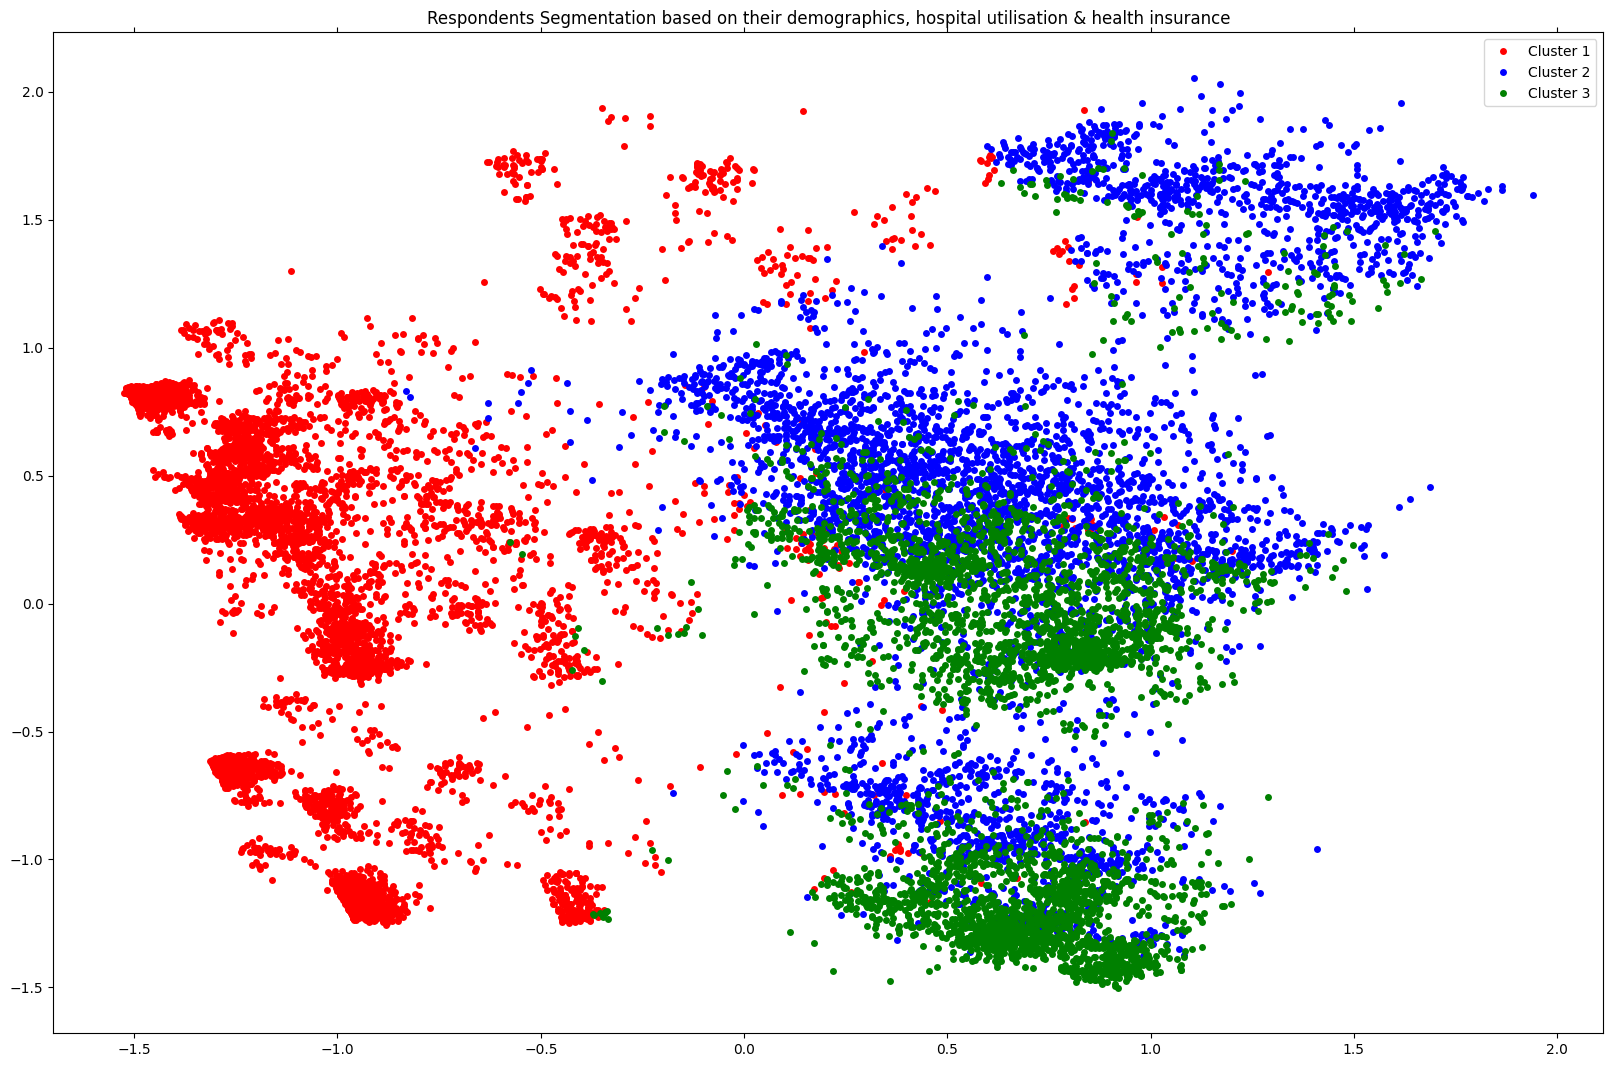

In [89]:
cluster_visualization(df_dum, columns = df_dum.columns[:-1], labels = df_dum["kproto_cluster_label"])

In [232]:
# The explained variance ratio for the 2 principal components is ~60%. The plot may not be ideal to look into for
# cluster visualization

In [91]:
score = silhouette_score(df_dum[df_dum.columns[:-1]], df_dum["kproto_cluster_label"], metric='cosine')

In [92]:
score

0.20297068882965272

### Aglomerative Clustering

In [36]:
df = pd.read_sql('select * from P_DEMO_HUQ_HIQ', conn)

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [37]:
# remove INDFMPIR and replace with INDFMPIR_imputed
df = df.drop("INDFMPIR", axis = 1)
df = df[~df.isna().any(axis = 1)]
df = df.rename(columns = {"INDFMPIR_imputed":"INDFMPIR"})

# copy dataframe
df_temp = df.copy()

In [38]:
# segragating features into nominal, ordinal and numeric
nominal_cols = [
    "RIAGENDR"
    ,"RIDRETH3"
    ,"DMDBORN4"
    ,"DMDMARTZ"
    ,"RIDEXPRG"
    ,"SIALANG"
    ,"SIAPROXY"
    ,"SIAINTRP"
    ,"HUQ030"
    ,"HUQ071"
    ,"HUQ090"
    ,"HIQ011"
    ,'HIQ032A'
    ,'HIQ032B'
    ,'HIQ032C'
    ,'HIQ032D'
    ,'HIQ032E'
    ,'HIQ032H'
    ,'HIQ032I'
    ,'HIQ270'
    ,'HIQ210'
]

ordinal_cols = [
    "DMDYRUSZ"
    ,"DMDEDUC2"
    ,"HUQ010"
    ,"HUQ051"
]

numeric_cols = [
    "RIDAGEYR"
    ,"RIDAGEMN"
    ,"INDFMPIR"
]

In [39]:
# covert 1=>0, 2=>1
enc_1_0_cols = ["DMDBORN4"
               ,"SIALANG"
               ,"HIQ032A"]
for col in enc_1_0_cols:
    df[col] = np.where(df[col] == 1, 0, 1)
    
# covert 1=>1, 2=>0
enc_1_0_cols = ["SIAPROXY"
               ,"SIAINTRP"
               ,"HUQ071"
               ,"HUQ090"
               ,"HIQ011"
               ,"HIQ032A"]
for col in enc_1_0_cols:
    df[col] = np.where(df[col] == 1, 1, 0)


In [40]:
one_hot_enc_cols = ["RIDRETH3"
                   ,"RIDRETH1"
                   ,"DMDMARTZ"
                   ,"RIDEXPRG"
                   ,"HUQ030"
                   ,"HIQ270"
                   ,"HIQ210"]

In [41]:
df[["HUQ051","HUQ030","HUQ010","HIQ210","HIQ270"]] = df[["HUQ051","HUQ030","HUQ010","HIQ210","HIQ270"]].astype("Int32")

In [42]:
df_dum = pd.get_dummies(df[demo_cols + hiq_cols + huq_cols ], columns = [col for col in one_hot_enc_cols if col in demo_cols + huq_cols + hiq_cols])

In [43]:
# remove age in years columns since age in months is reflective of it.
numeric_cols = [
#     "RIDAGEYR"
    "RIDAGEMN"
    ,"INDFMPIR"
]

In [44]:
df_dum[numeric_cols + ordinal_cols] = MinMaxScaler().fit_transform(df_dum[numeric_cols + ordinal_cols])
df_dum.head()

,RIAGENDR,RIDAGEMN,DMDBORN4,SIALANG,SIAPROXY,SIAINTRP,DMDYRUSZ,DMDEDUC2,INDFMPIR,HIQ011,HIQ032A,HIQ032B,HIQ032C,HIQ032D,HIQ032E,HIQ032H,HIQ032I,HUQ010,HUQ071,HUQ090,HUQ051,RIDRETH3_1,RIDRETH3_2,RIDRETH3_3,RIDRETH3_4,RIDRETH3_6,RIDRETH3_7,RIDRETH1_1,RIDRETH1_2,RIDRETH1_3,RIDRETH1_4,RIDRETH1_5,DMDMARTZ_1,DMDMARTZ_2,DMDMARTZ_3,DMDMARTZ_4,RIDEXPRG_1,RIDEXPRG_2,RIDEXPRG_3,RIDEXPRG_4,HIQ270_1,HIQ270_2,HIQ270_3,HIQ210_1,HIQ210_2,HIQ210_3
0,0,0.0250,0,0,1,0,1.00,1.0,0.932,1,0,0,0,0,0,0,0,0.00,0,0,0.125,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0
1,1,0.1625,0,0,1,0,1.00,1.0,0.166,1,1,0,0,0,0,1,0,0.25,0,1,0.000,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0
2,0,0.0250,0,0,1,0,1.00,1.0,0.612,1,0,0,0,1,0,0,0,0.00,0,0,0.250,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0
3,1,0.3625,1,0,0,0,0.25,0.8,1.000,1,0,0,0,0,0,0,0,0.50,0,0,0.125,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0
4,1,0.2625,1,0,0,0,0.50,0.6,1.000,1,0,0,0,0,0,0,0,0.00,0,0,0.125,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0


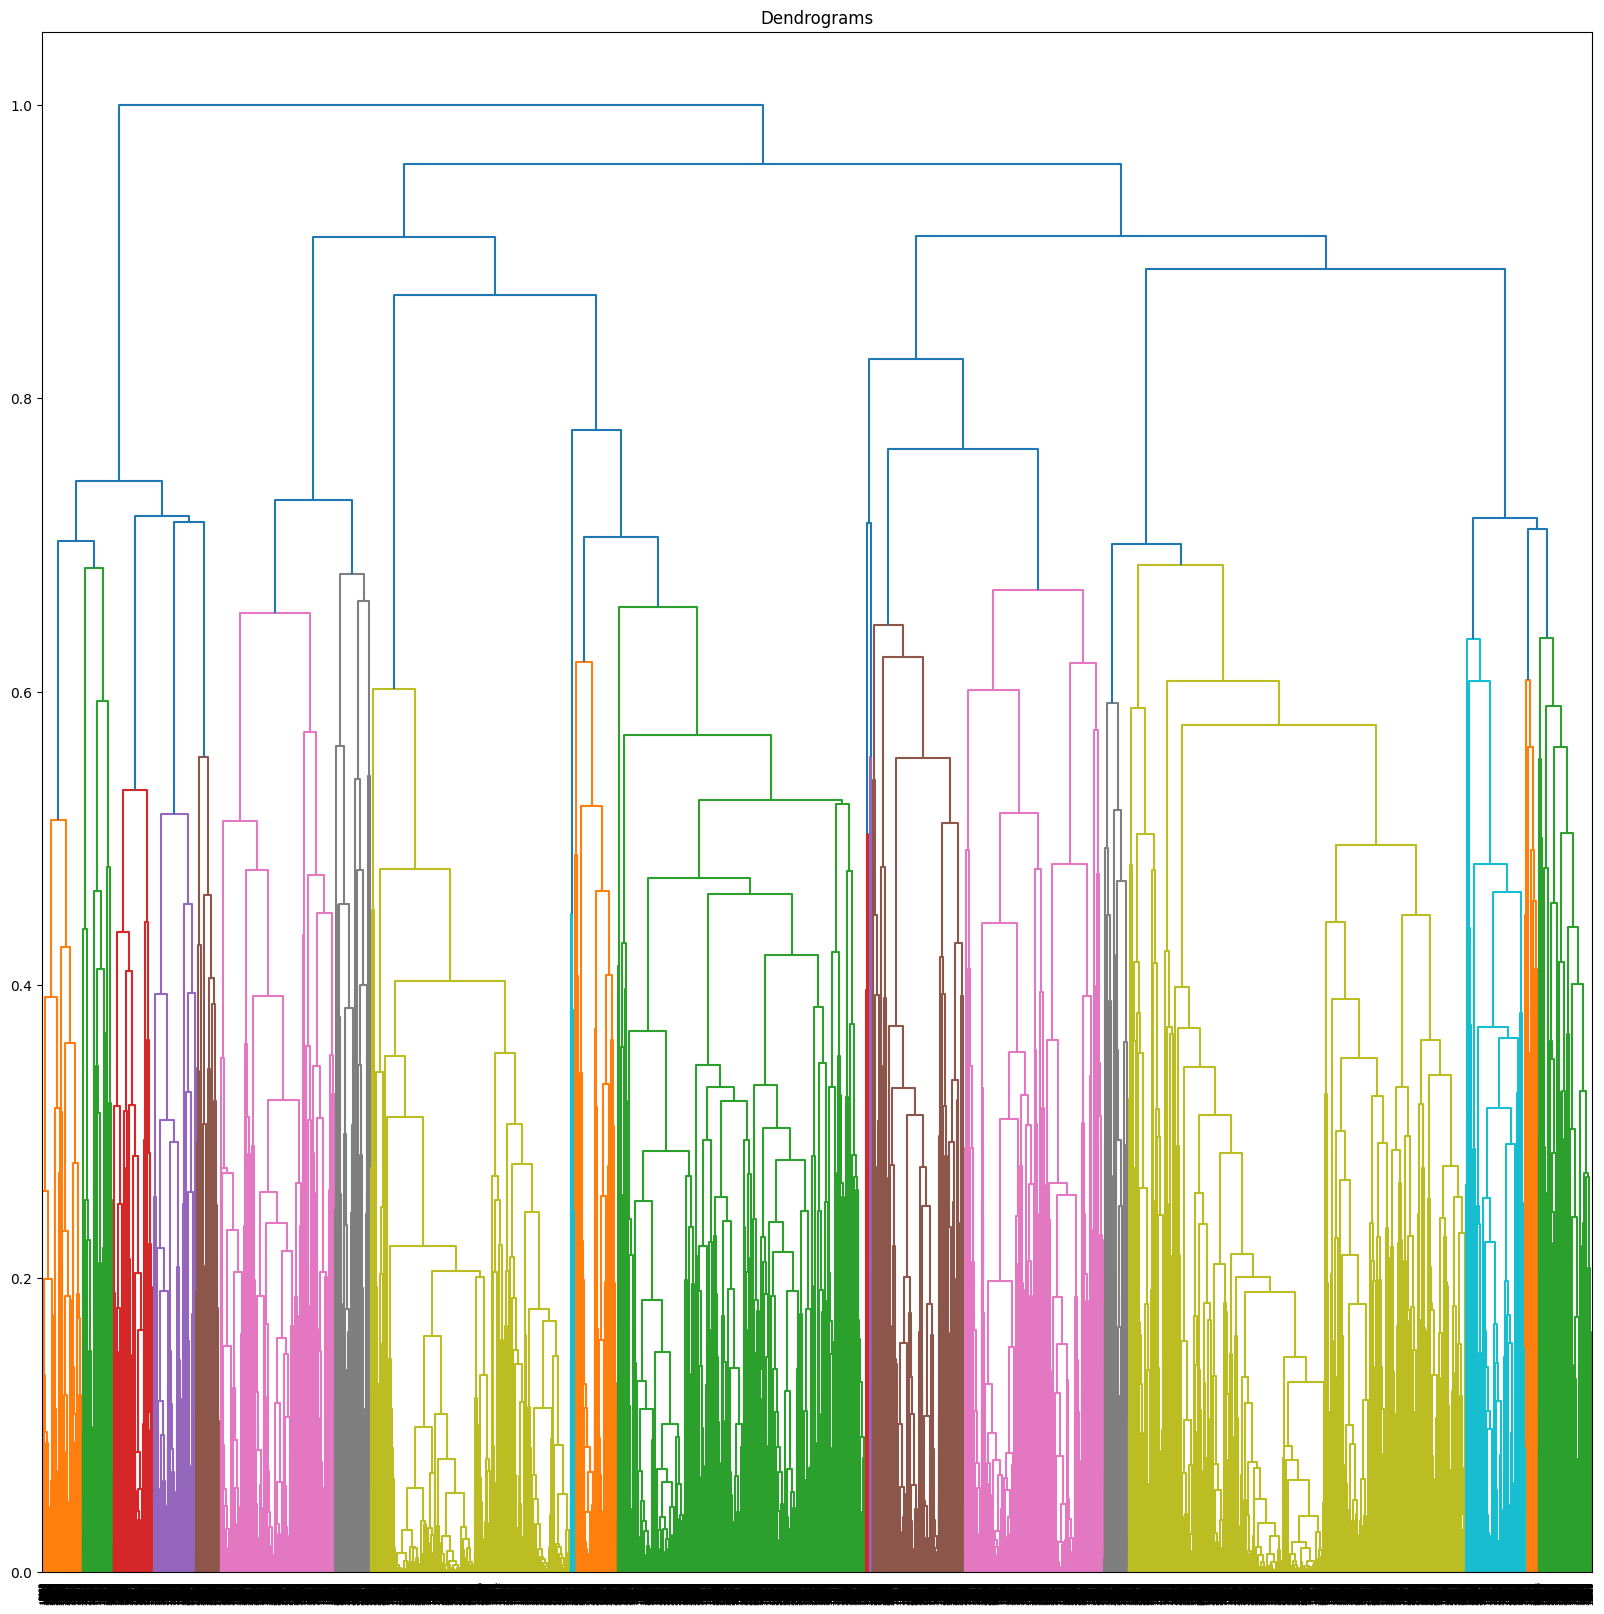

In [45]:
plt.figure(figsize=(20, 20))
plt.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(df_dum, method='complete', metric='cosine'))
# plt.axhline(y=3.5, color='r', linestyle='--')

In [157]:
# plt.figure(figsize=(20, 20))
# plt.title("Dendrograms")
# dend = shc.dendrogram(shc.linkage(df_dum, method='complete', metric='minkowski'))
# # plt.axhline(y=3.5, color='r', linestyle='--')

In [67]:
clustering = AgglomerativeClustering(n_clusters=5, affinity='cosine', linkage='complete').fit(df_dum)

In [68]:
clustering

AgglomerativeClustering(affinity='cosine', linkage='complete', n_clusters=5)

In [69]:
pd.Series(clustering.labels_).value_counts()

0    7048
3    3502
2    1733
1    1501
4    1213
dtype: int64

In [70]:
df_dum["clusters_agl"] = clustering.labels_

In [71]:
df_temp["clusters_agl"] = clustering.labels_

/home/students/risaac/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


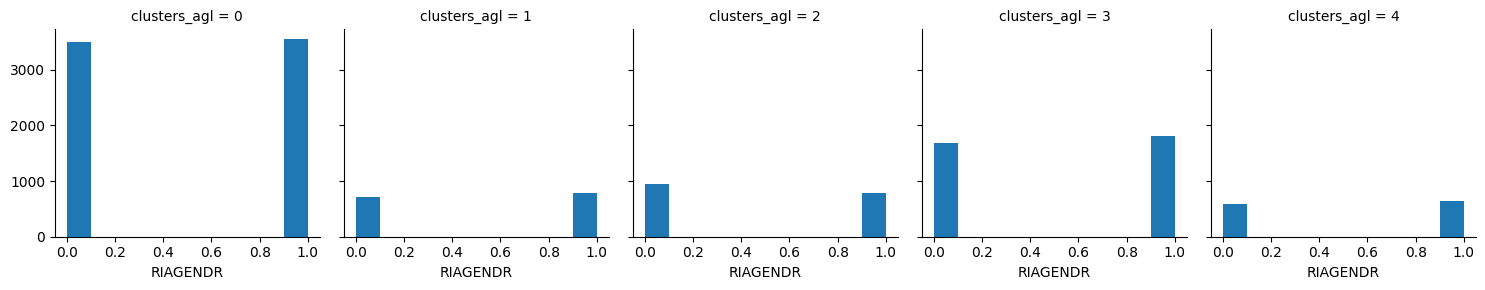

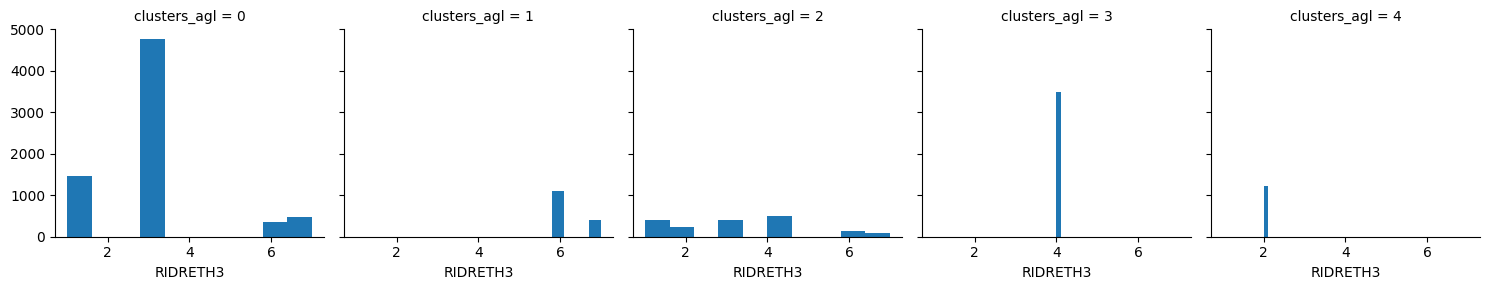

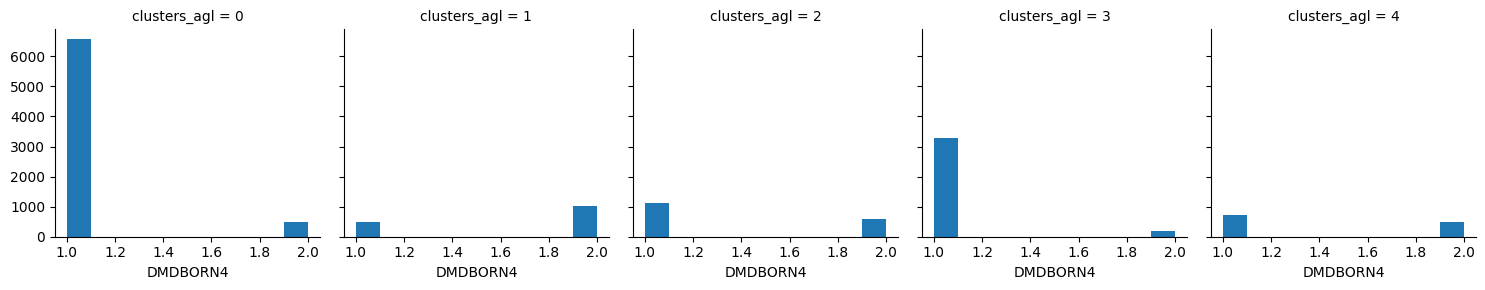

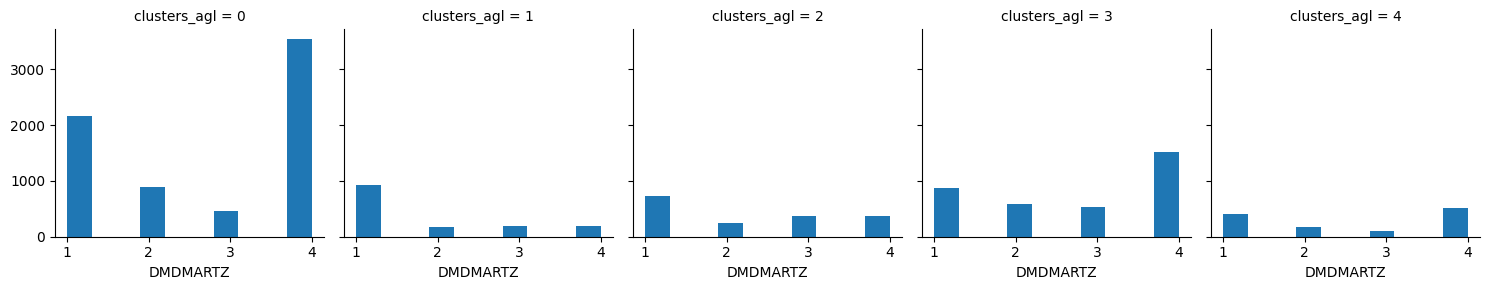

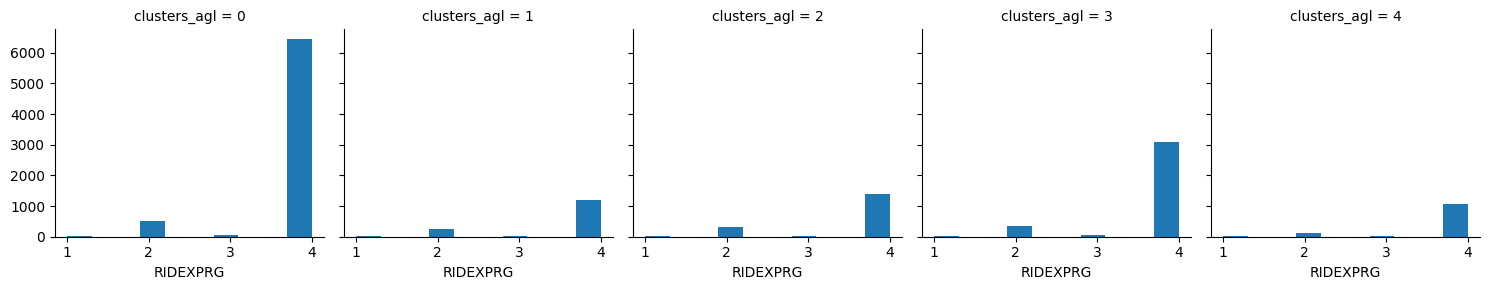

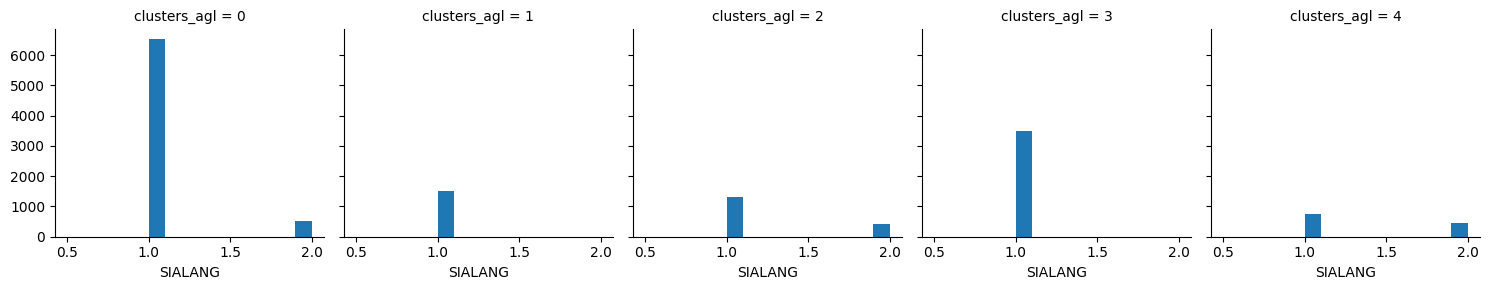

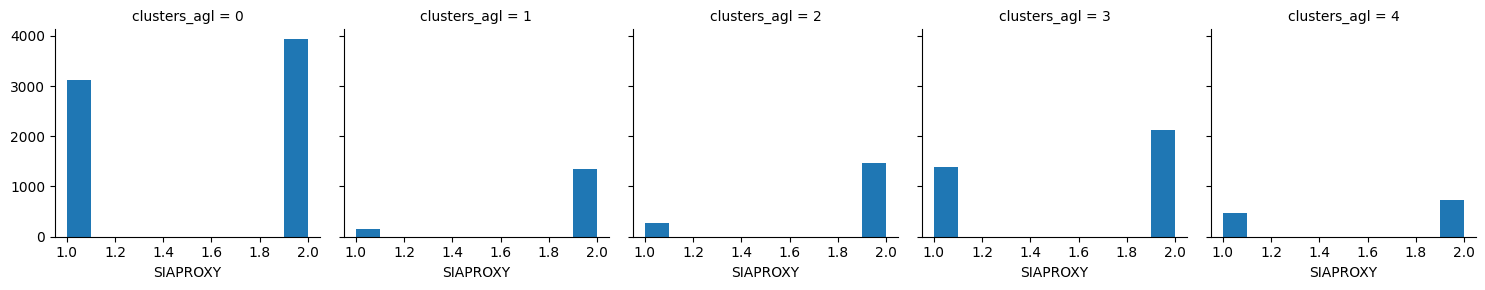

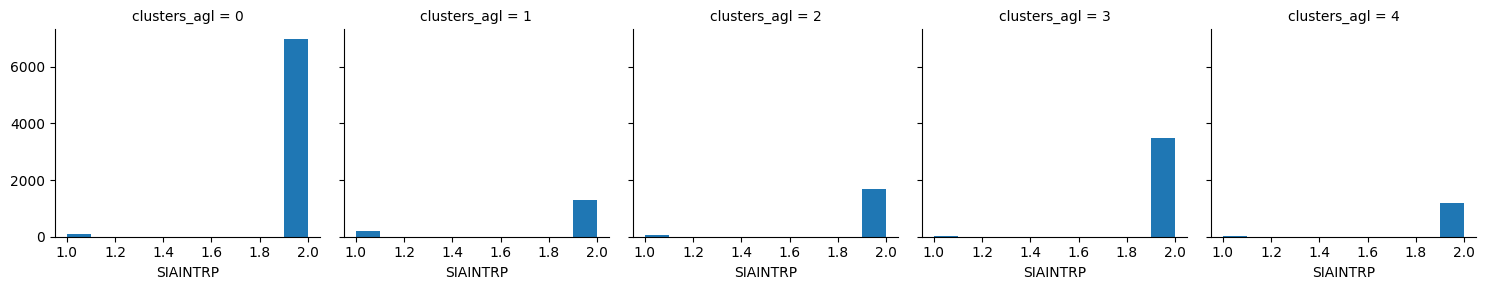

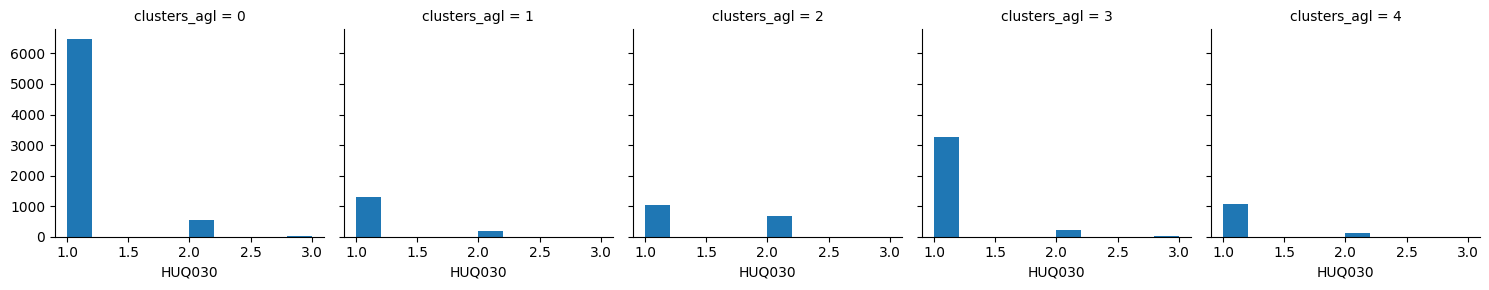

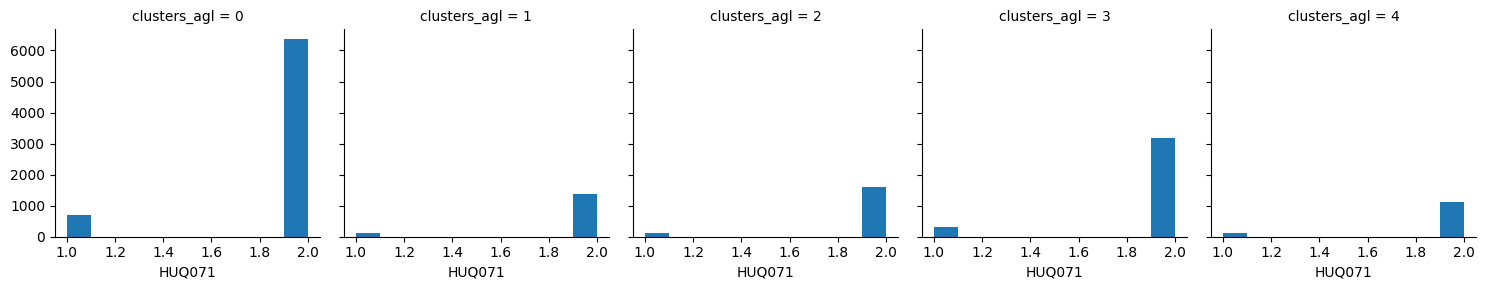

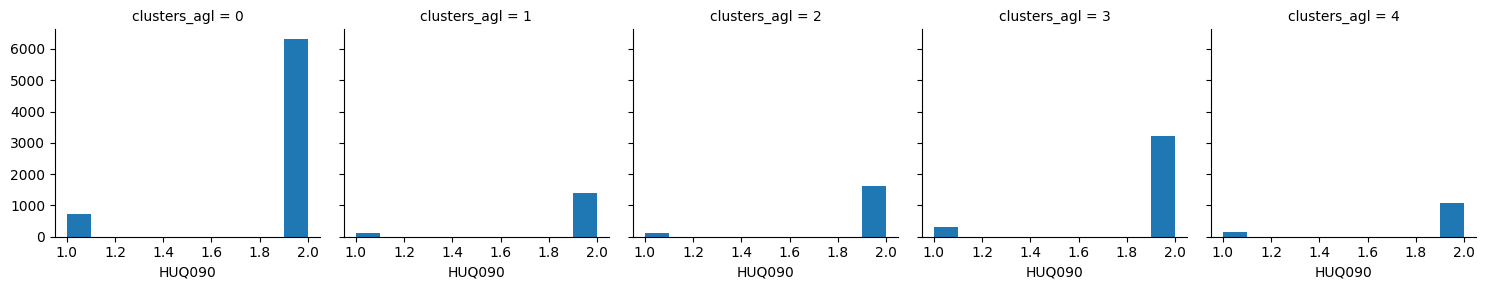

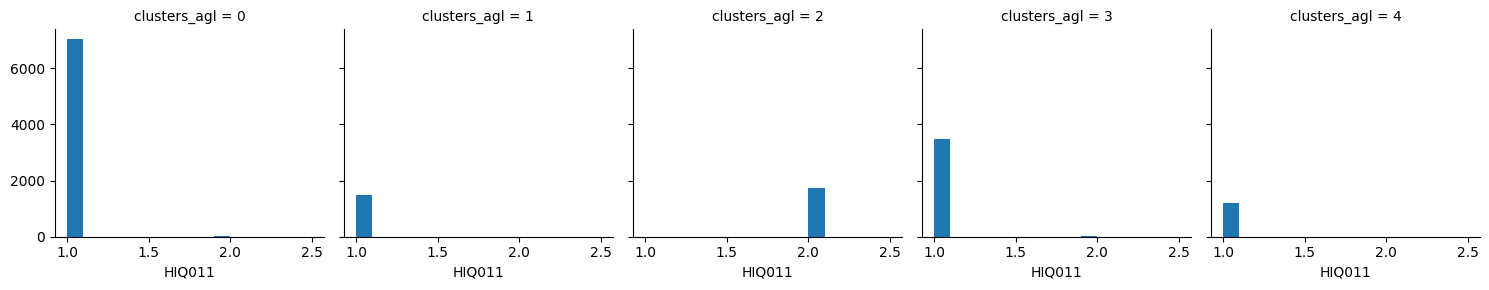

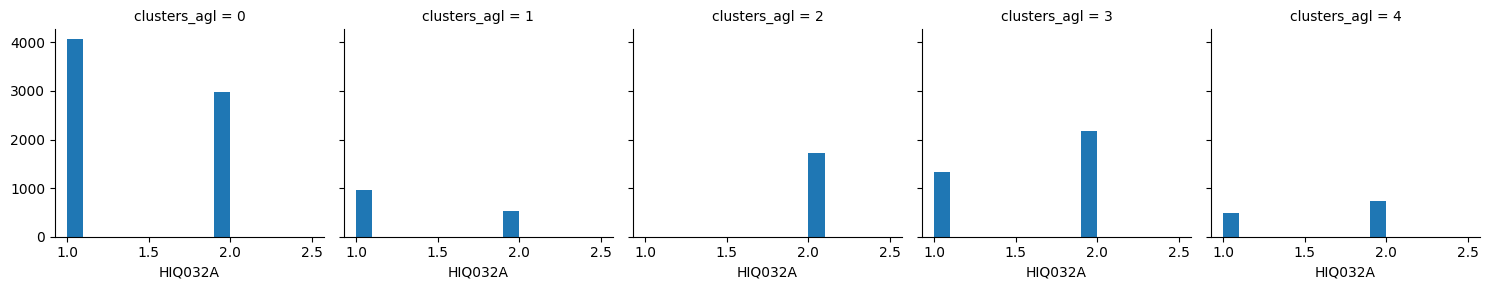

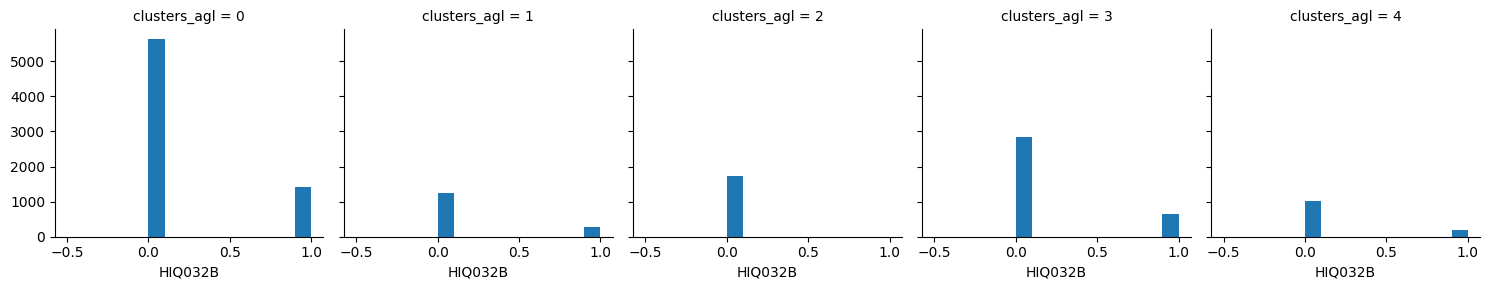

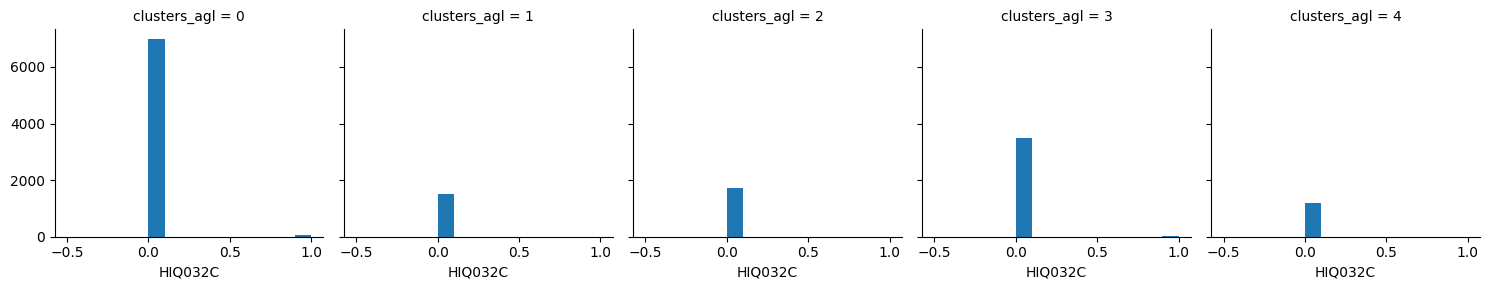

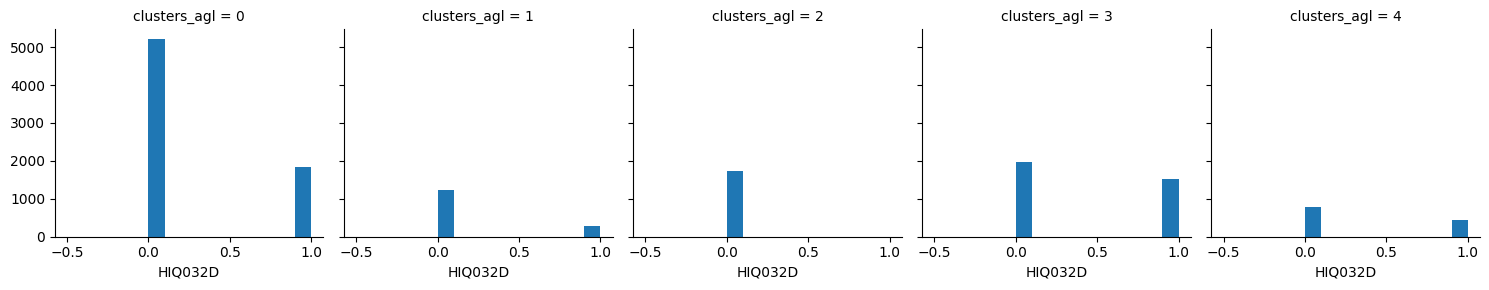

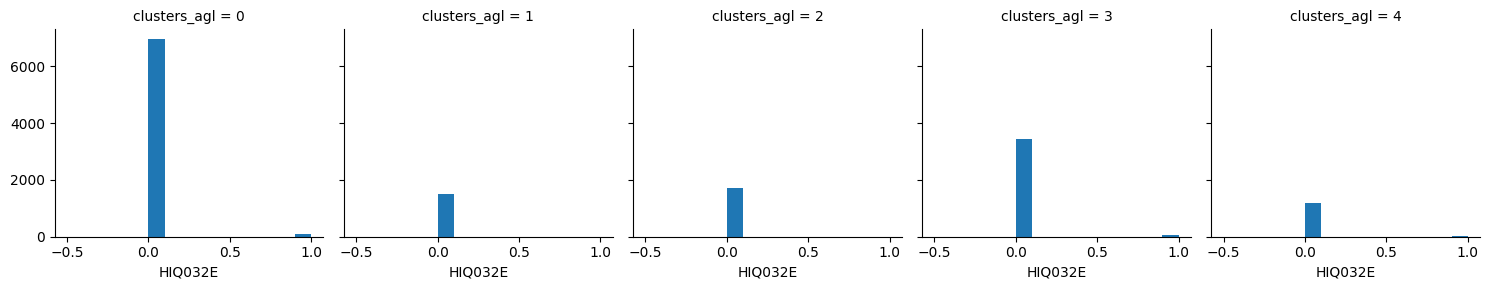

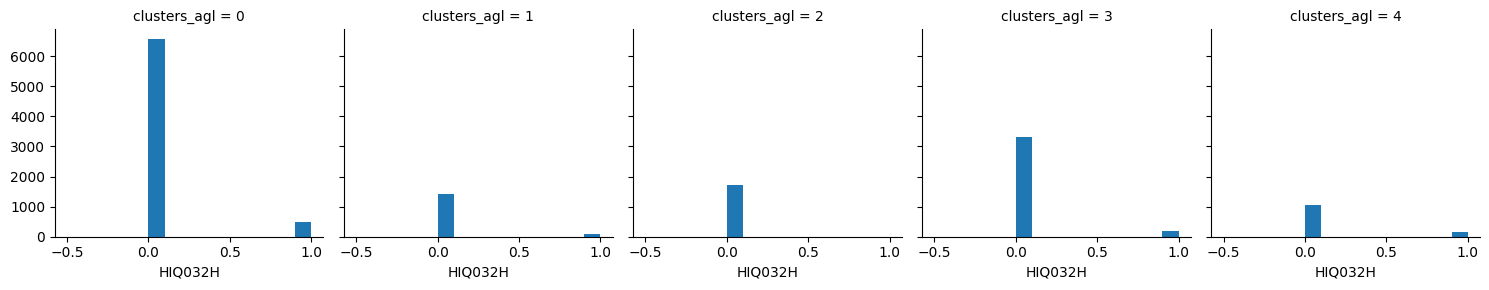

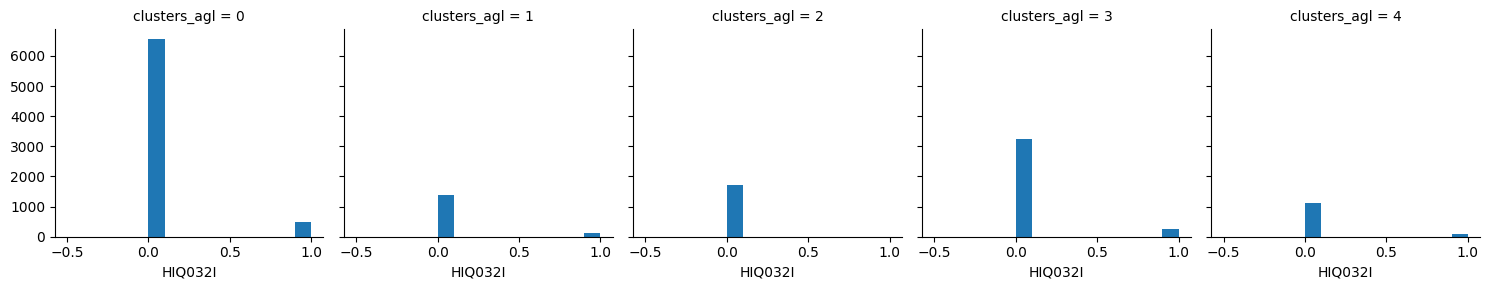

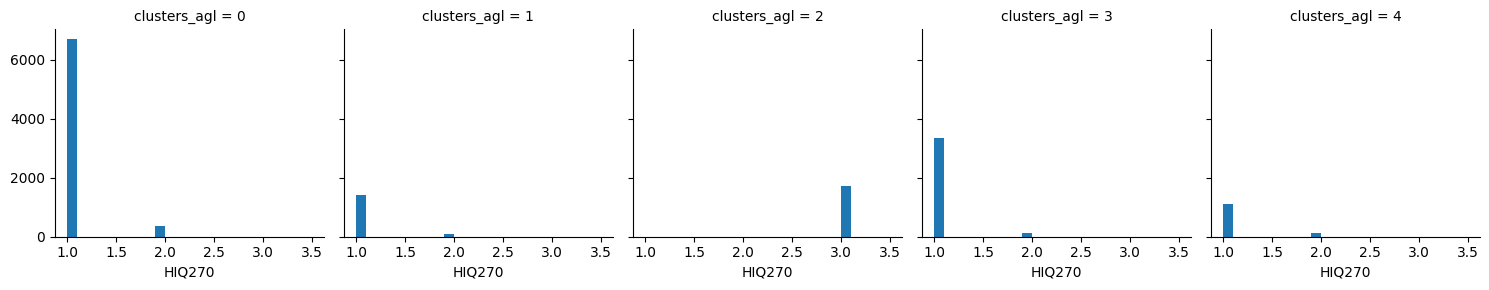

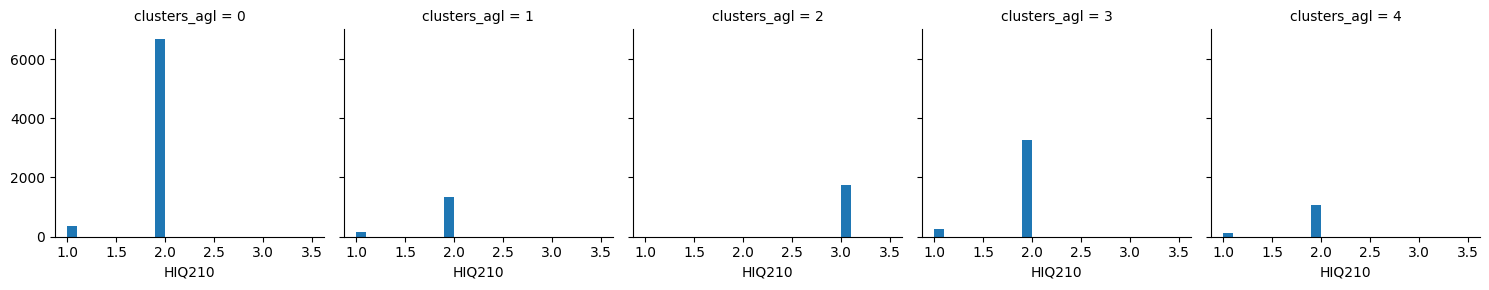

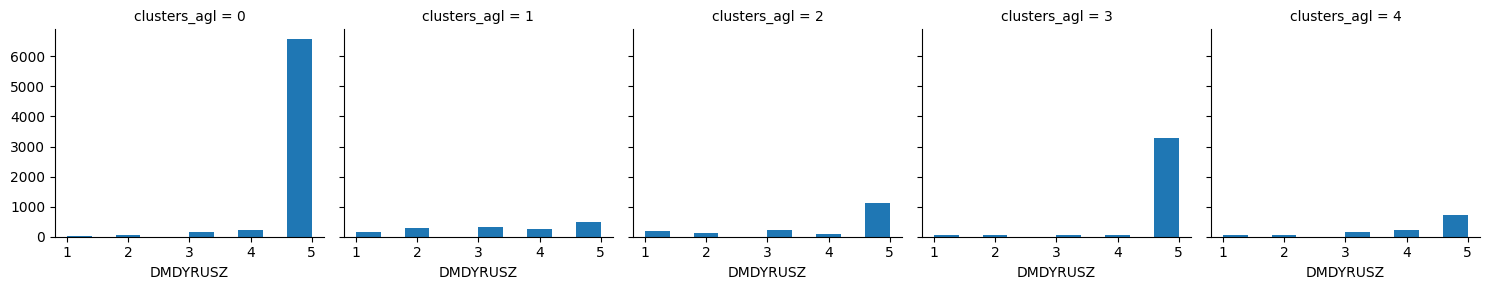

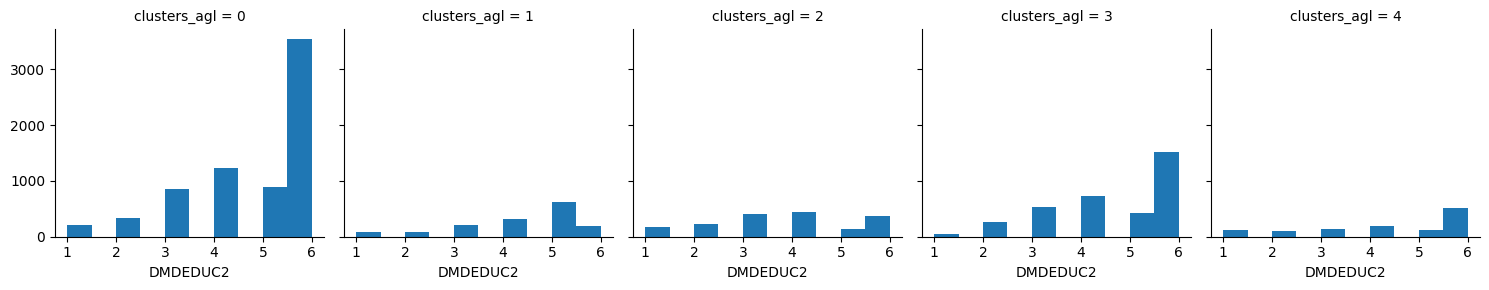

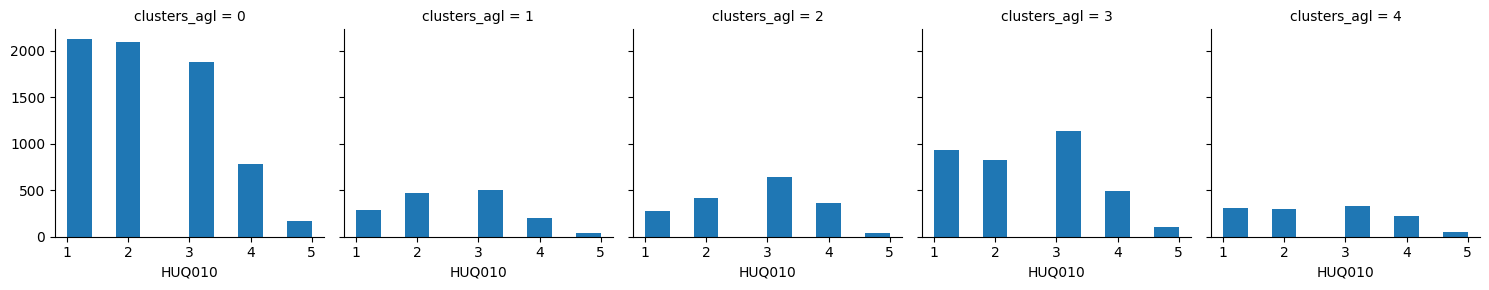

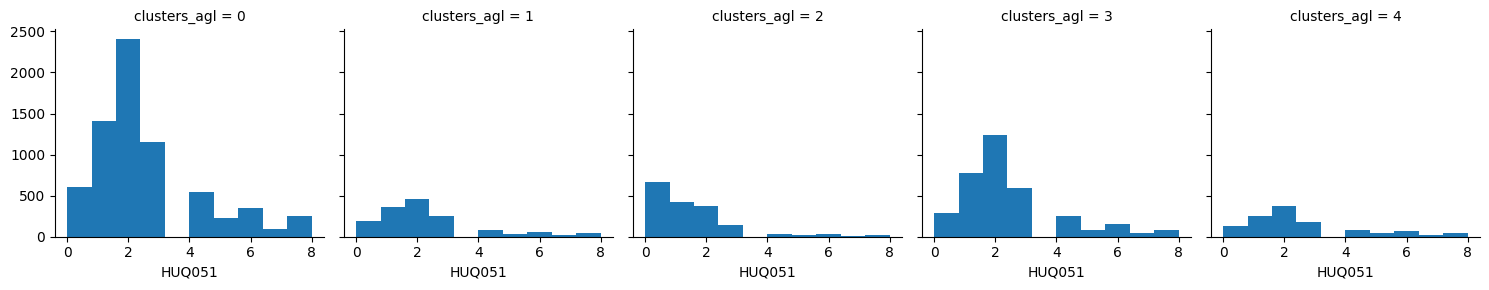

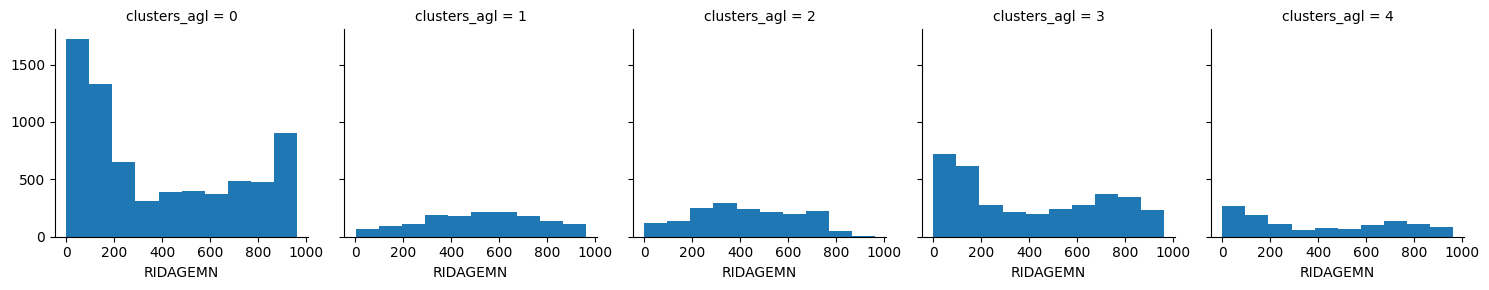

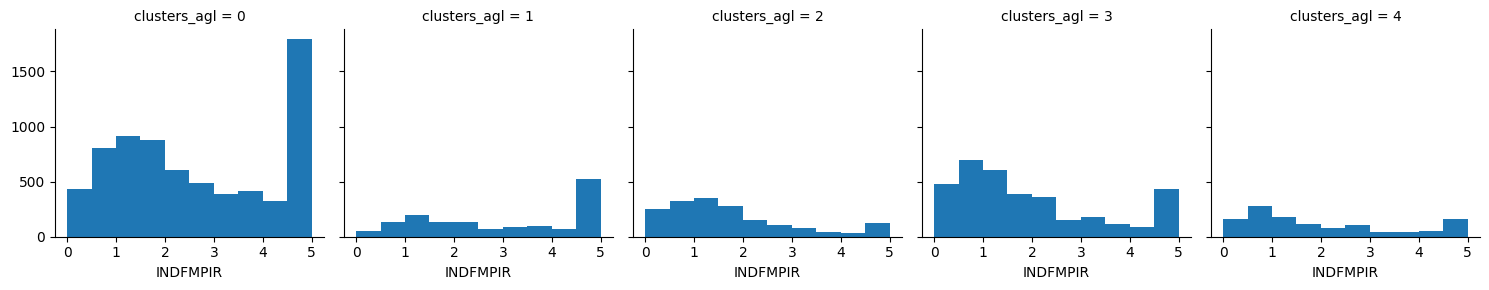

In [72]:
# cluster interpretation
for c in df_temp[nominal_cols + ordinal_cols + numeric_cols]:
    grid= sns.FacetGrid(df_temp[nominal_cols + ordinal_cols + numeric_cols + ['clusters_agl']], col='clusters_agl')
    grid.map(plt.hist, c)

In [73]:
# reference: https://medium.com/more-python-less-problems/principal-component-analysis-and-k-means-clustering-to-visualize-a-high-dimensional-dataset-577b2a7a5fe2

def cluster_visualization(df, columns, labels):
    
    df = df[columns]
    pca = PCA(2)
    pca.fit(df)
    X_PCA = pca.transform(df)
    X_PCA.shape
    print(pca.explained_variance_ratio_)    
    
    x, y = X_PCA[:, 0], X_PCA[:, 1]

    colors = {0: 'red'
              ,1: 'blue'
              ,2: 'green'
              ,3: 'yellow'
              ,4: 'orange'
#               ,5:'purple'
             }

    names = {0: 'Cluster 1'
             ,1: 'Cluster 2' 
             ,2: 'Cluster 3'
             ,3: 'Cluster 4'
             ,4: 'Cluster 5'
            }

    df = pd.DataFrame({'x': x, 'y':y, 'label':labels})
    groups = df.groupby('label')

    fig, ax = plt.subplots(figsize=(20, 13)) 

    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
                color=colors[name],label=names[name], mec='none')
        ax.set_aspect('auto')
        ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
        ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')

    ax.legend()
    ax.set_title("Respondents Segmentation based on their demographics, hospital utilisation & health insurance")
    plt.show()


[0.15800095 0.13639769]


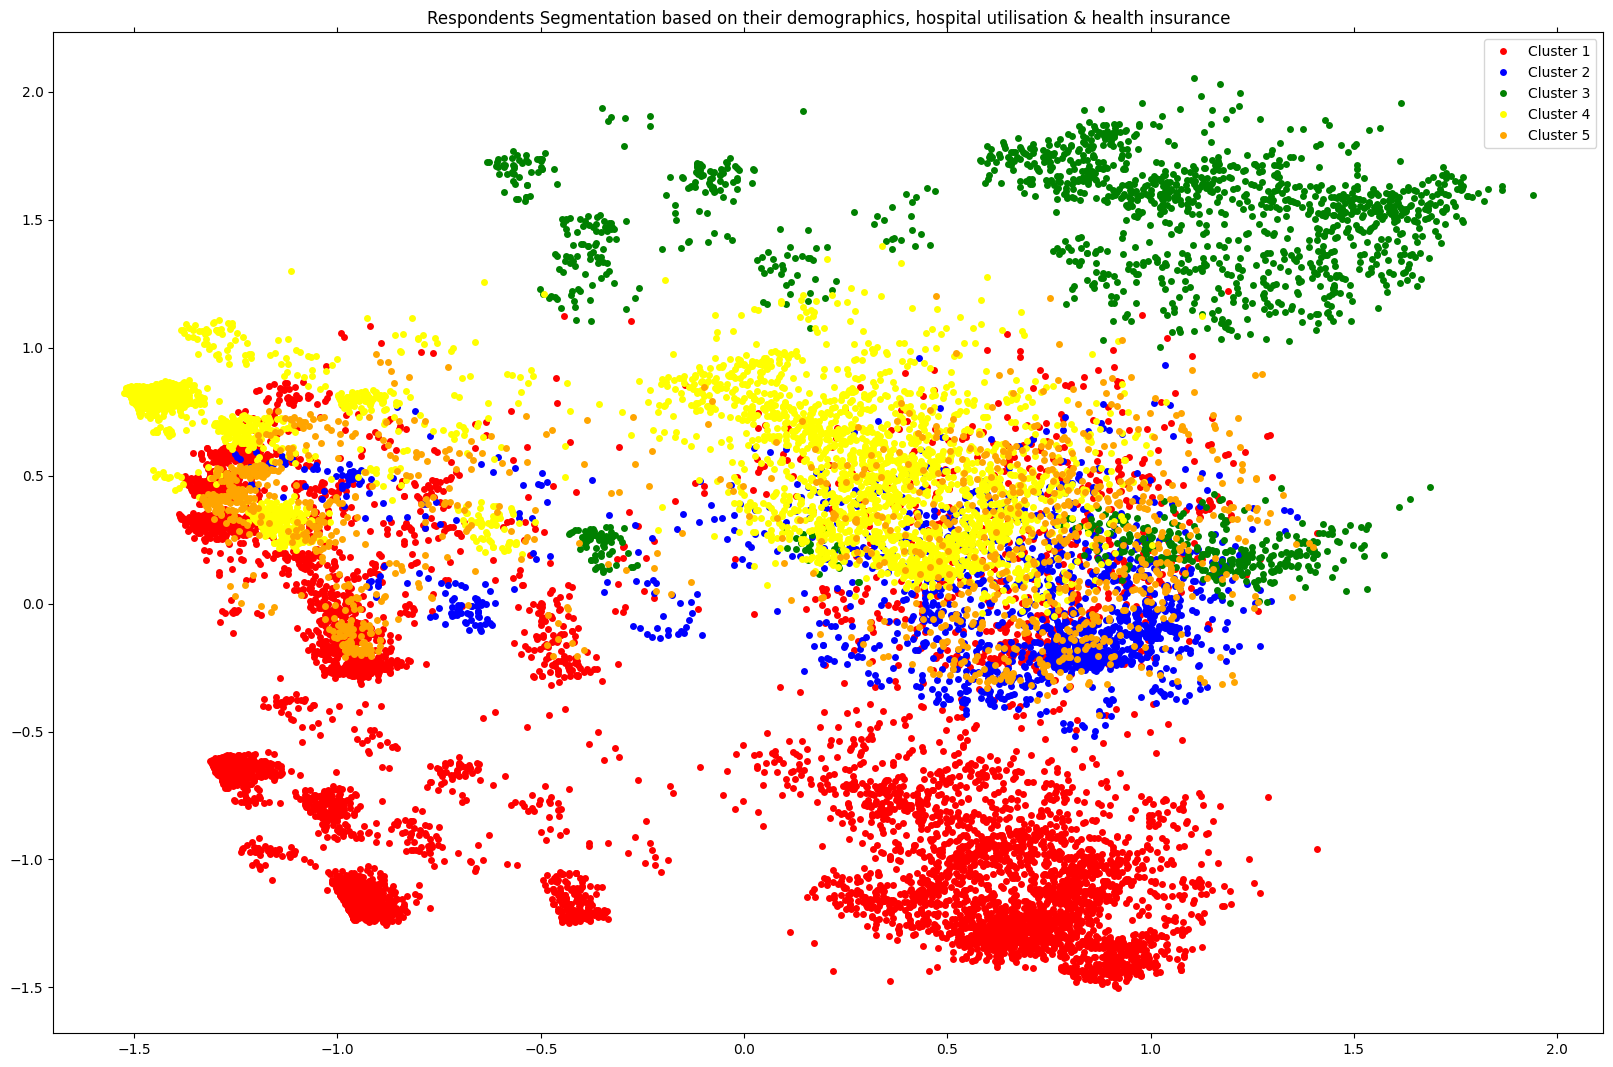

In [74]:
cluster_visualization(df_dum, columns = df_dum.columns[:-1], labels = df_dum["clusters_agl"])

In [82]:
score = silhouette_score(df_dum[df_dum.columns[:-1]], df_dum["clusters_agl"], metric='cosine')

In [83]:
score

0.27704231255187434

### Affinity Clustering

In [127]:
clustering_aff = AffinityPropagation().fit(np.array(df_dum))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:236: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


In [128]:
cluster_centers = clustering_aff.cluster_centers_

In [129]:
len(np.unique(clustering_aff.labels_))

572

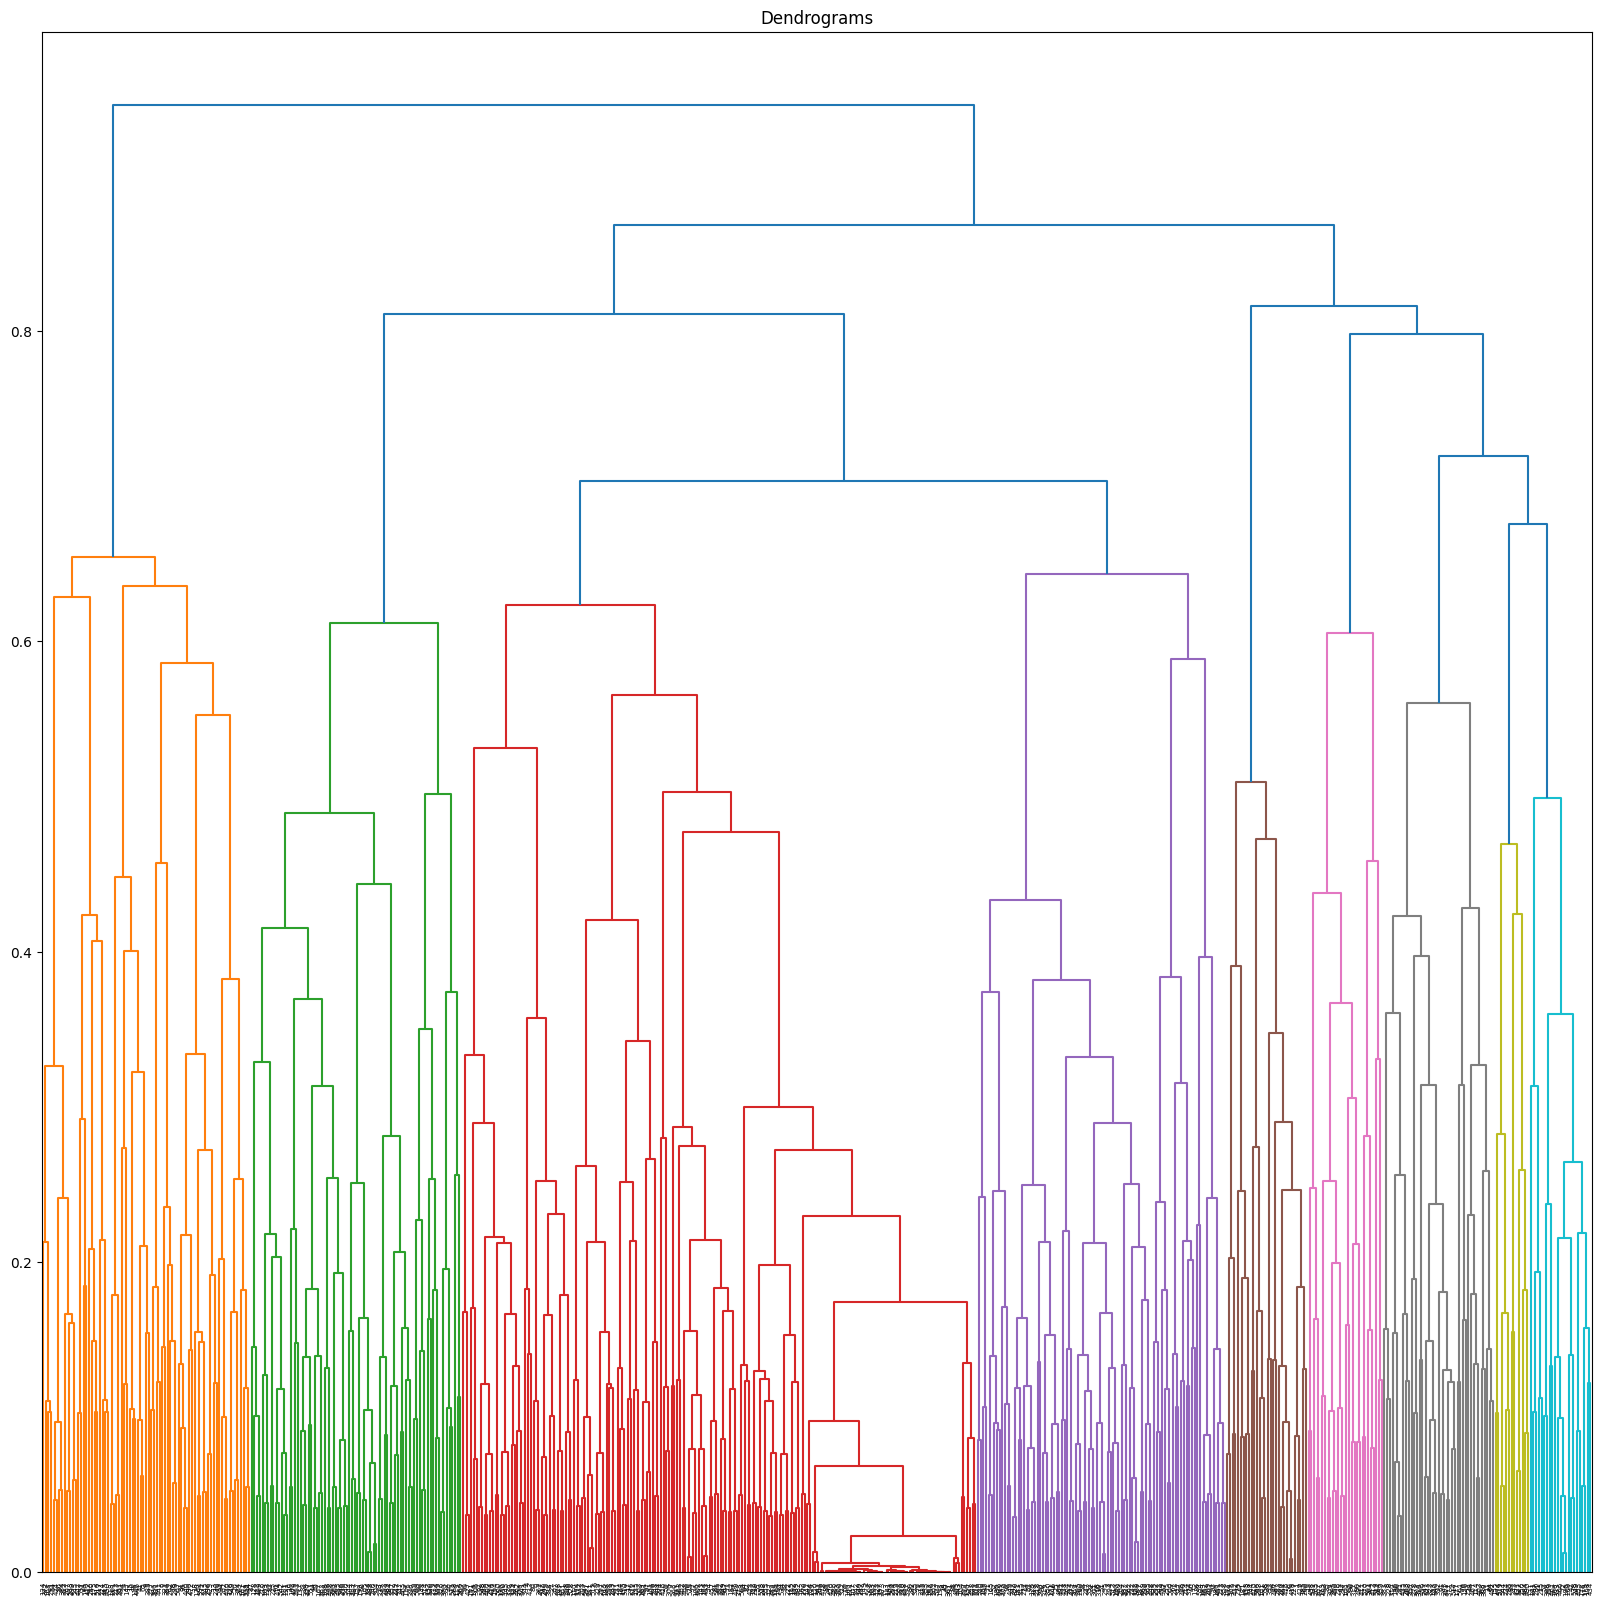

In [130]:
plt.figure(figsize=(20, 20))
plt.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(cluster_centers, method='complete', metric='cosine'))

In [131]:
clustering = AgglomerativeClustering(n_clusters=3, affinity='cosine', linkage='complete').fit(cluster_centers)

In [132]:
pd.Series(clustering.labels_).value_counts()

2    360
0    135
1     77
dtype: int64

In [133]:
cluster_centers = pd.DataFrame(cluster_centers)

In [134]:
cluster_centers["clusters_agl"] = clustering.labels_

/home/students/risaac/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


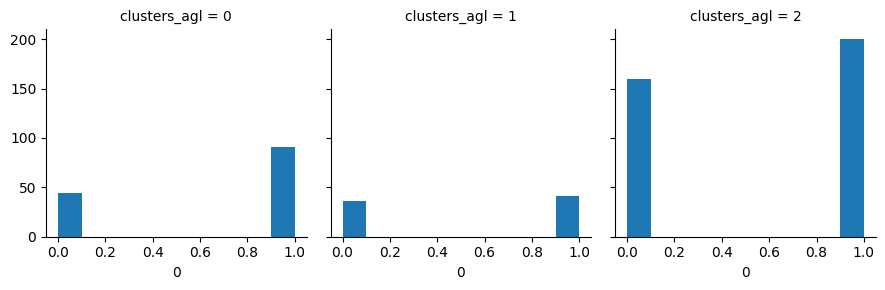

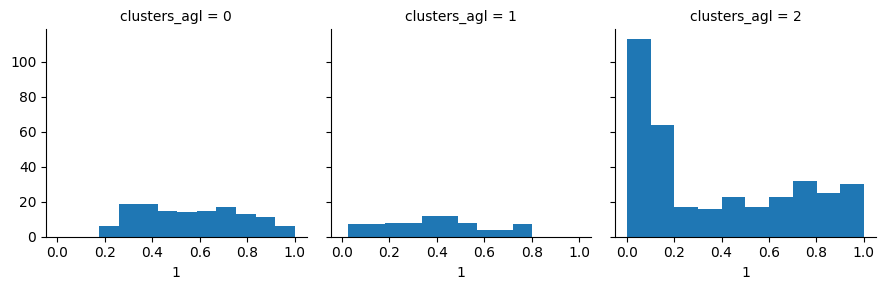

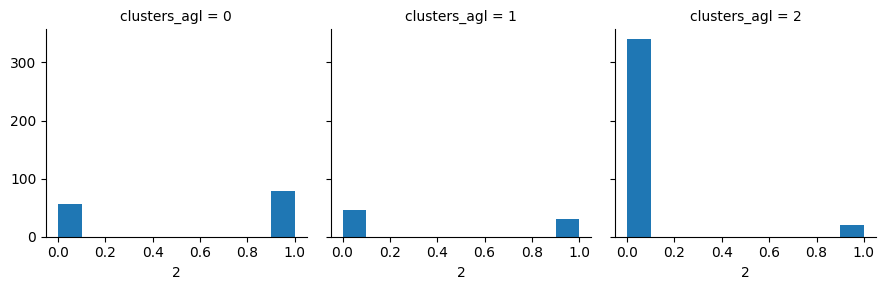

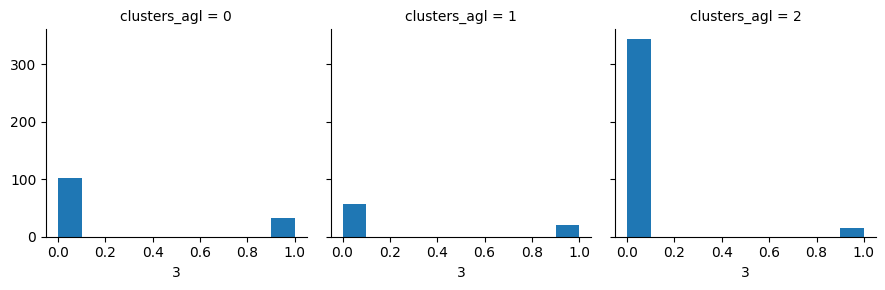

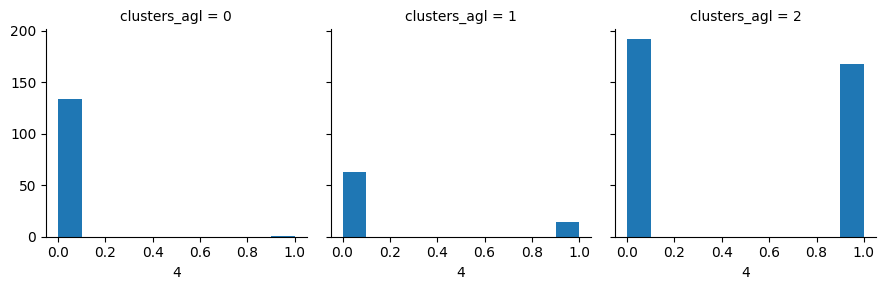

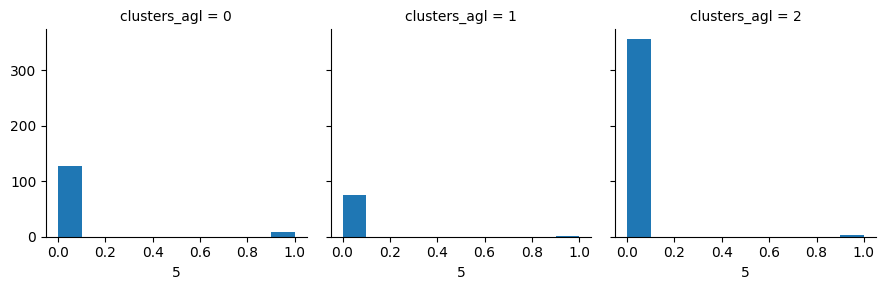

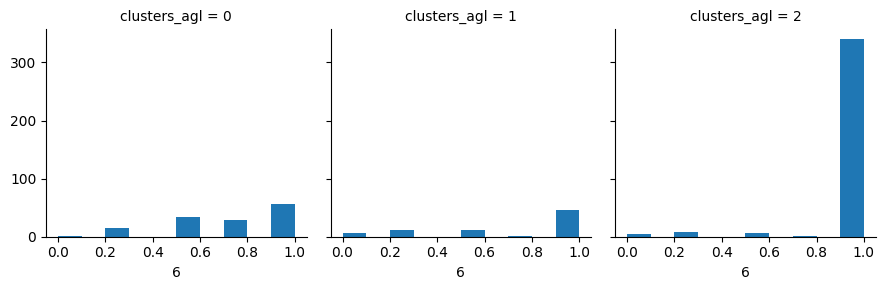

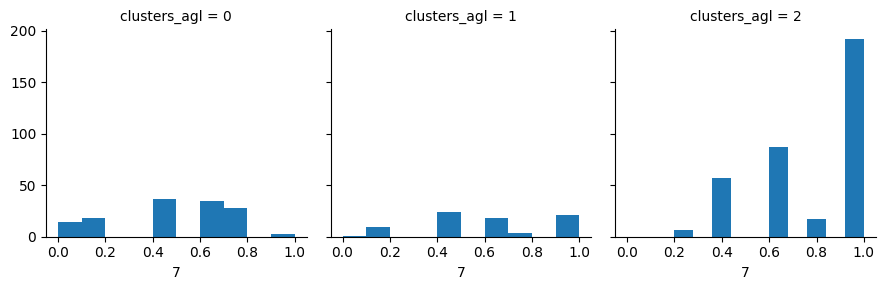

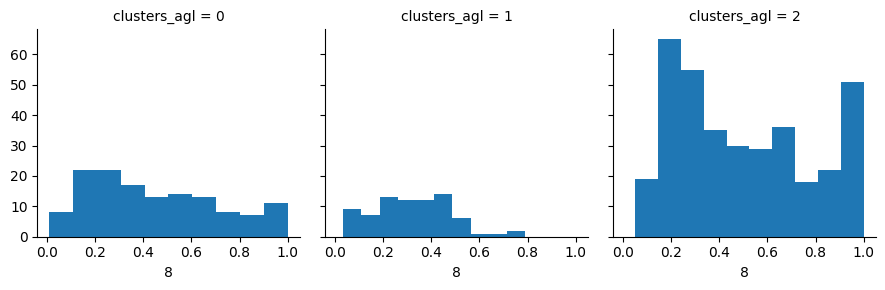

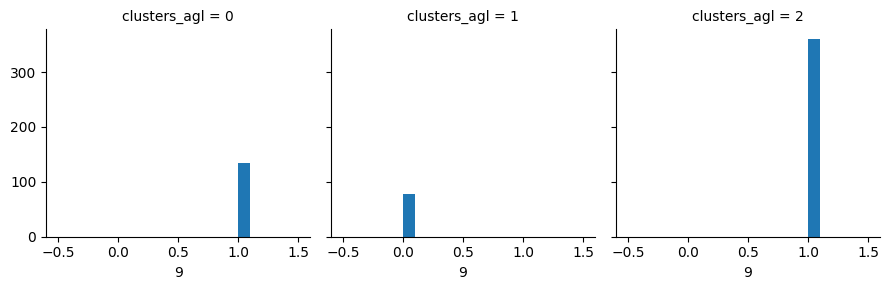

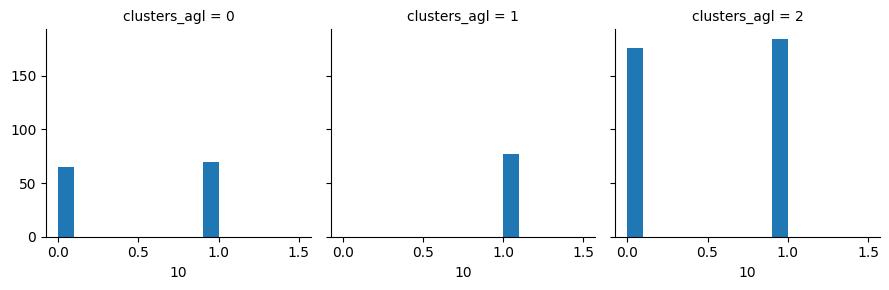

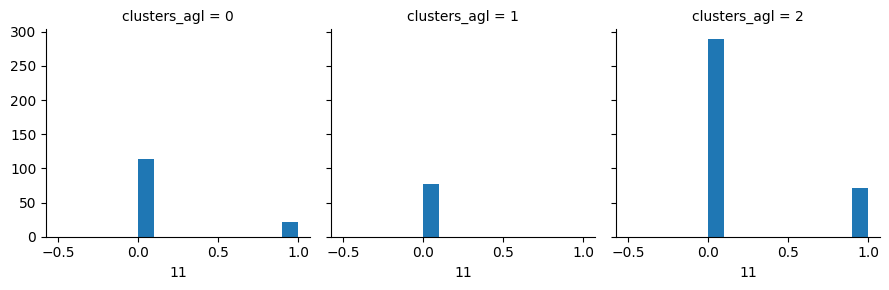

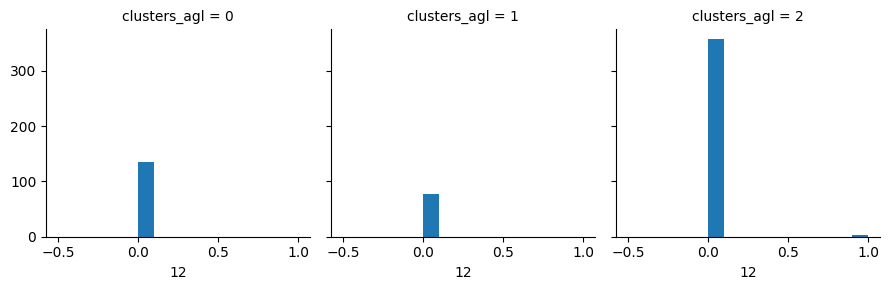

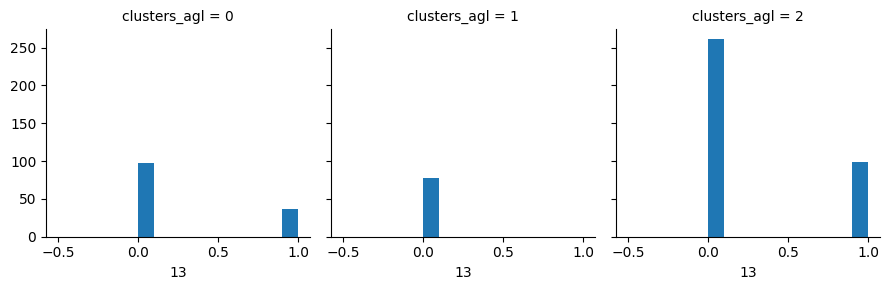

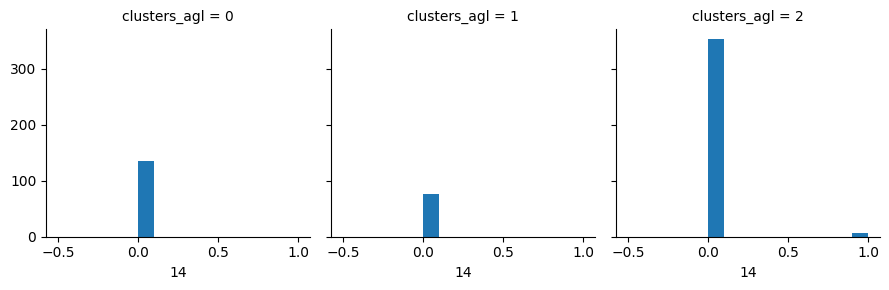

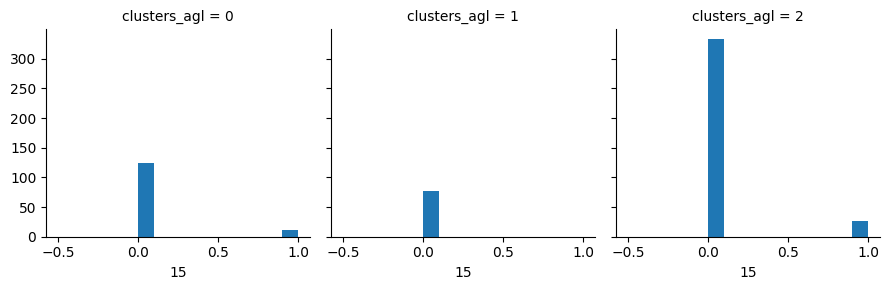

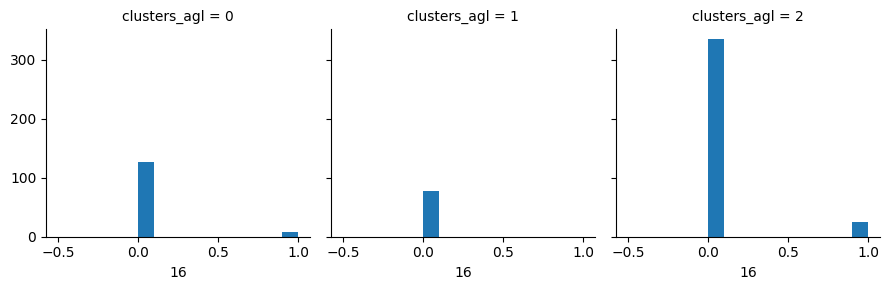

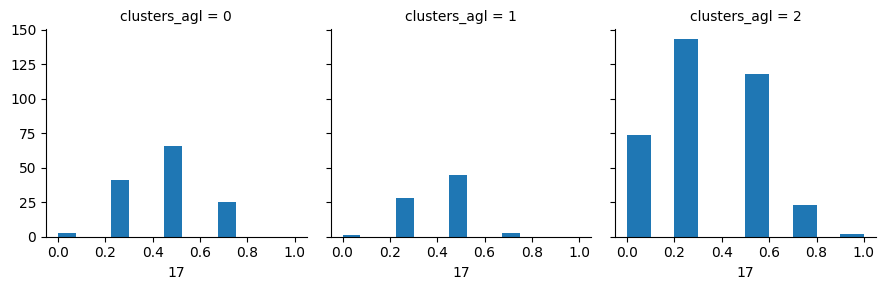

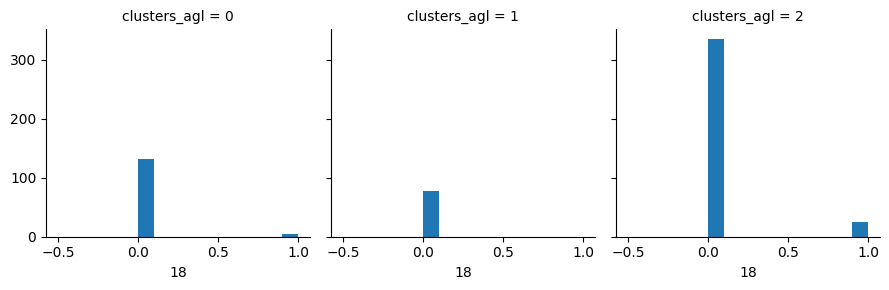

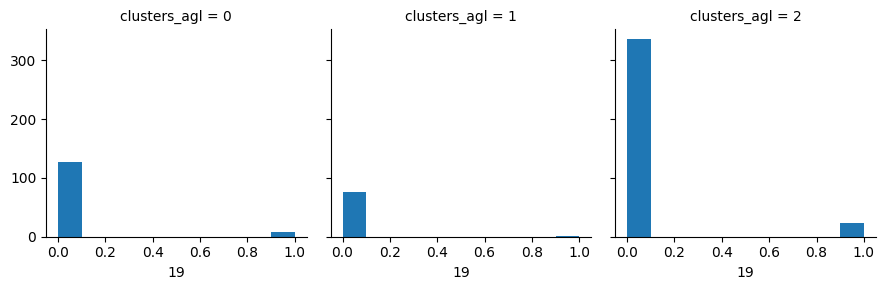

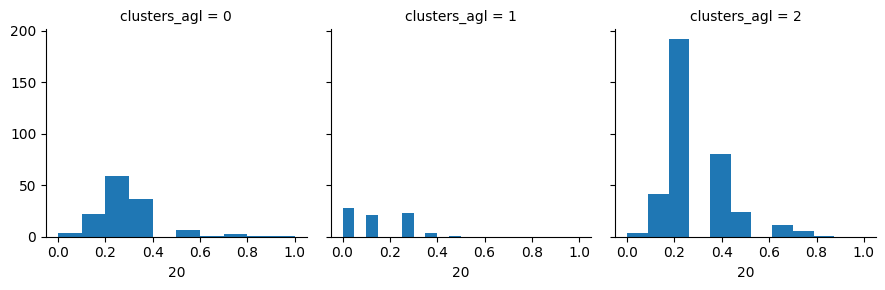

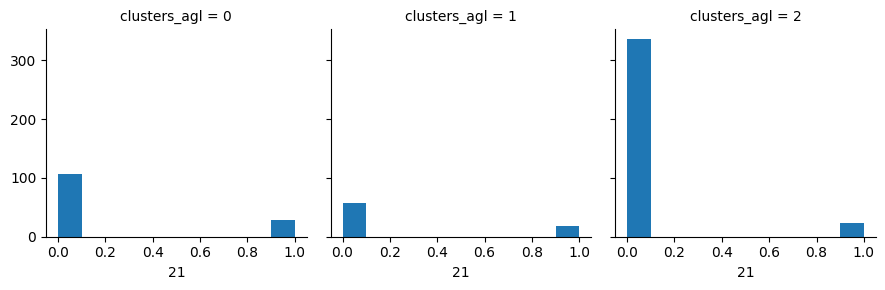

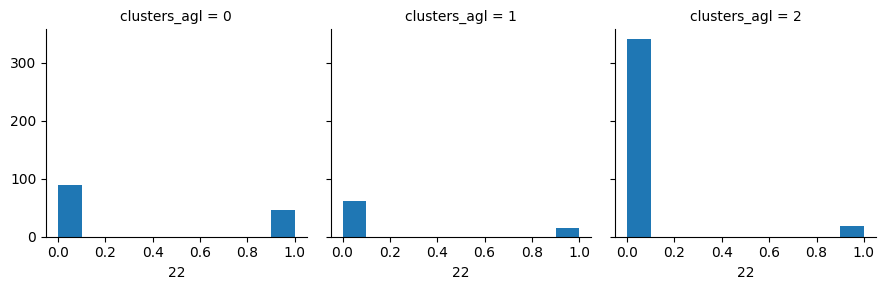

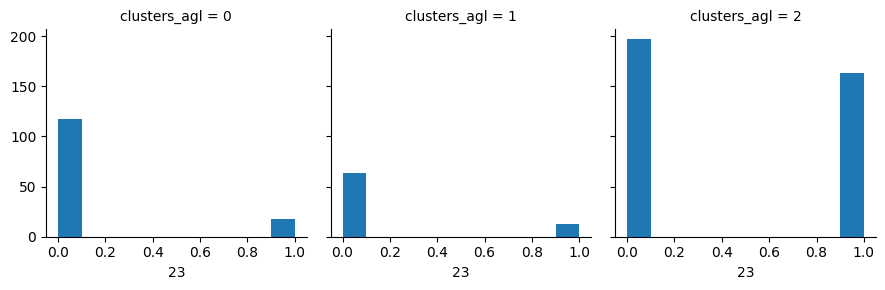

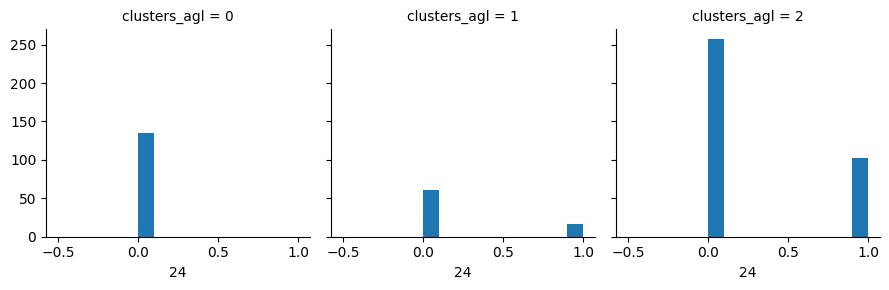

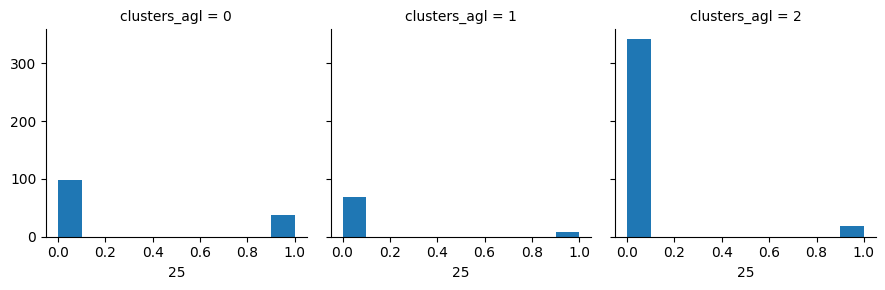

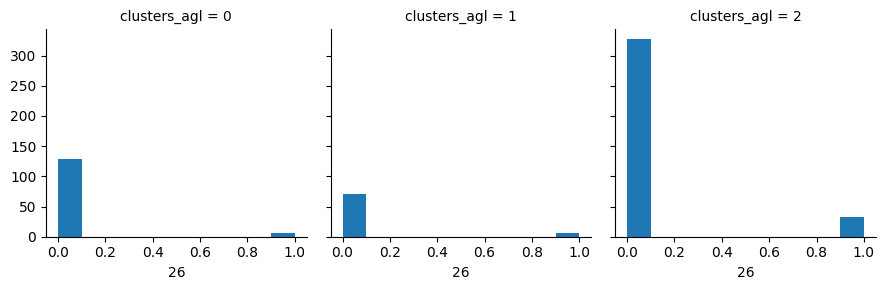

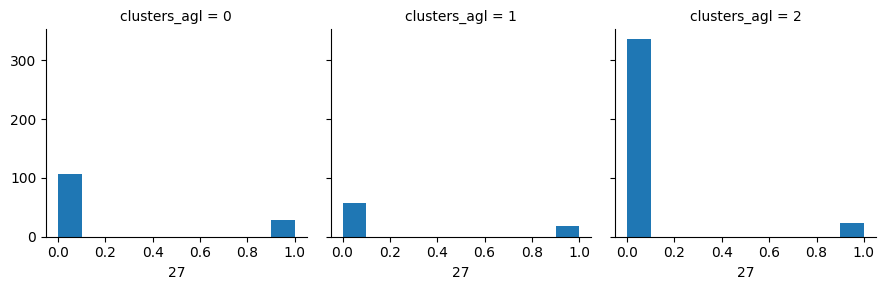

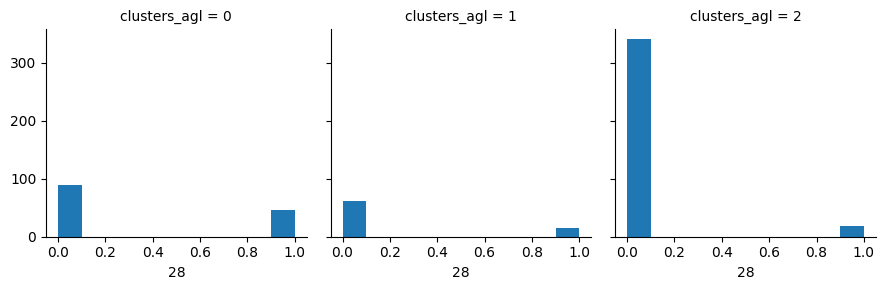

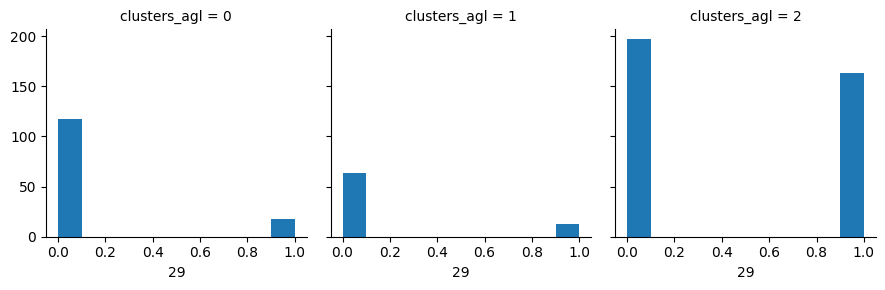

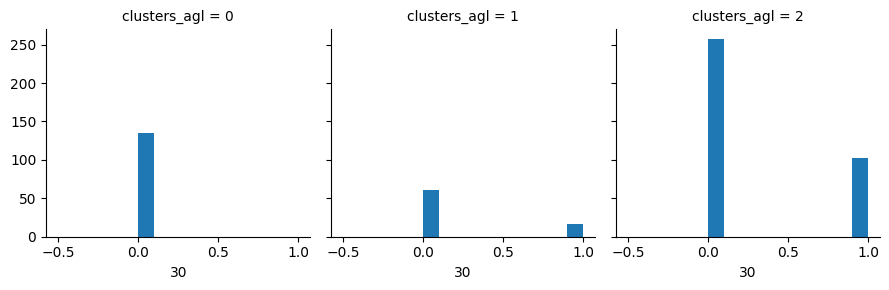

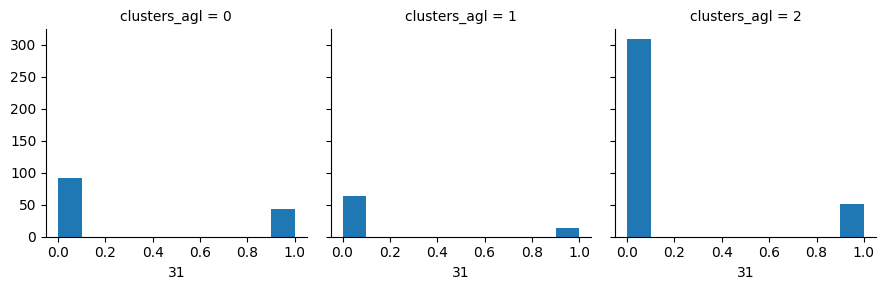

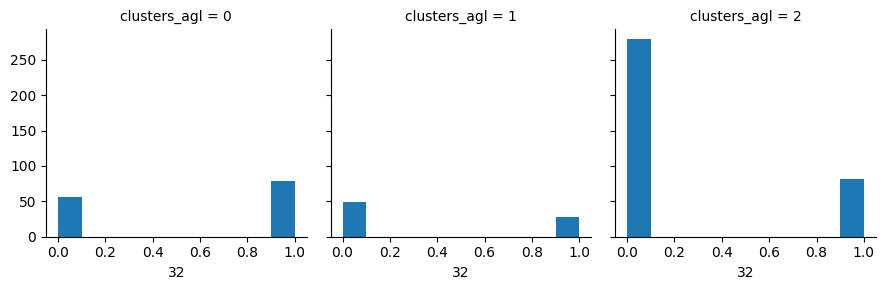

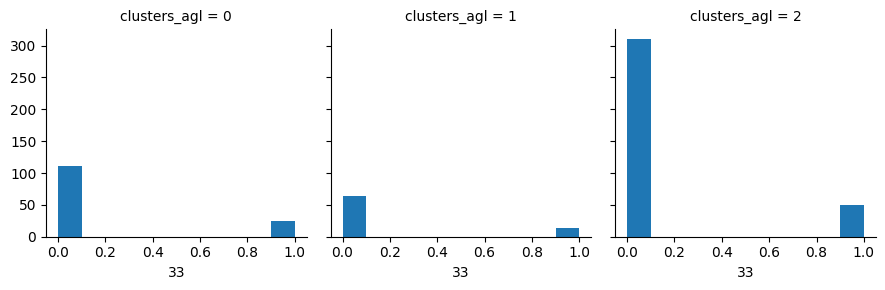

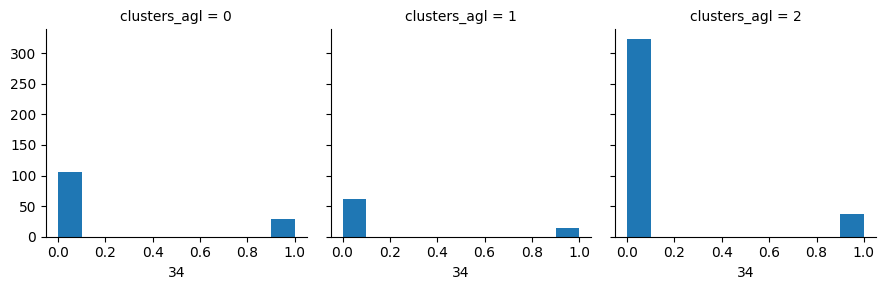

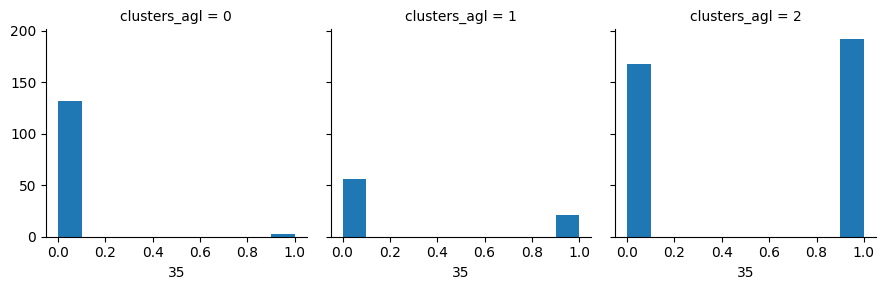

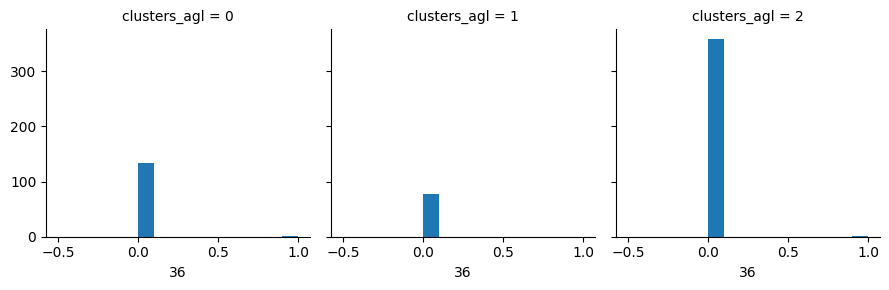

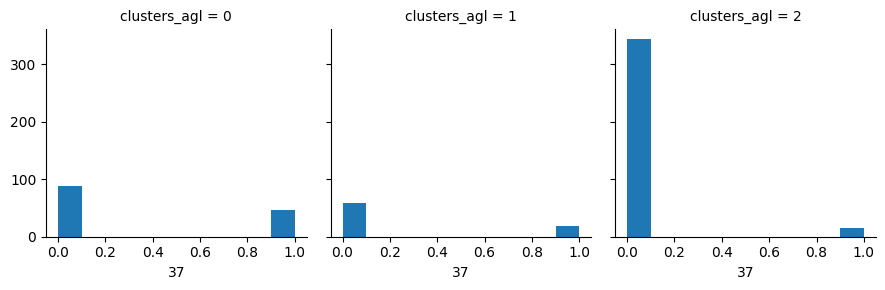

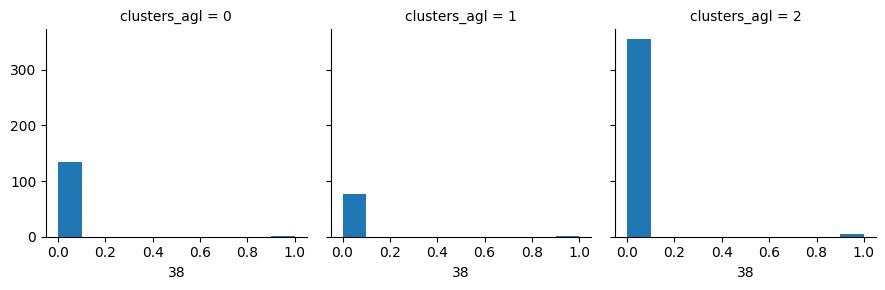

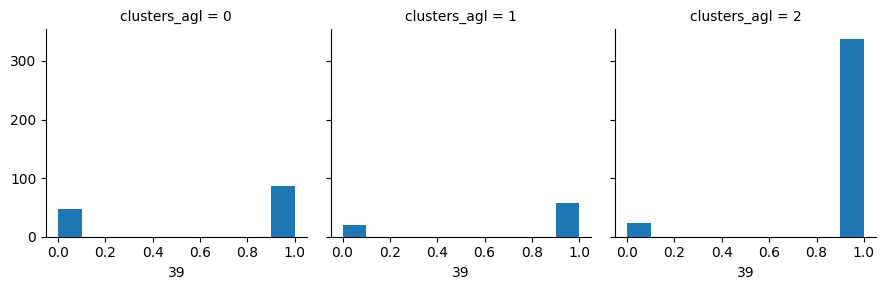

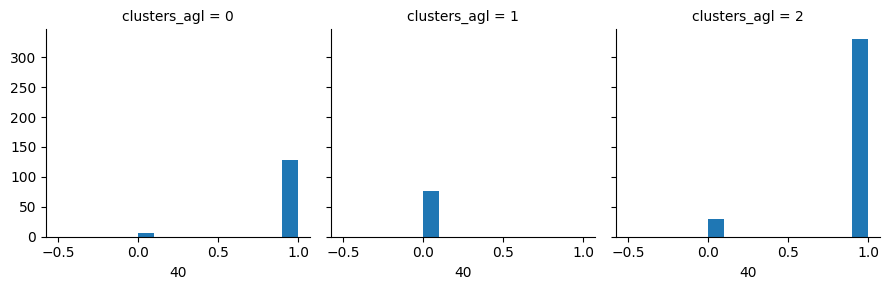

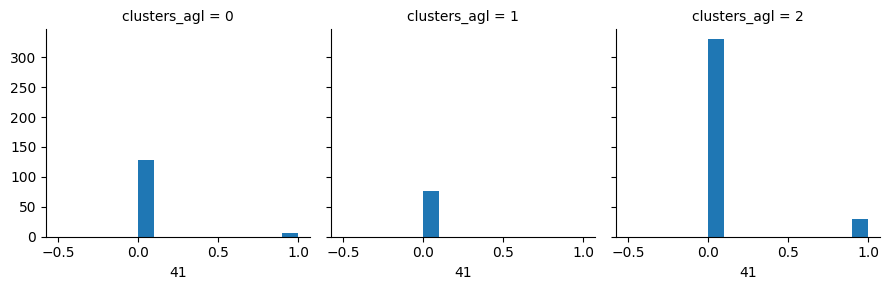

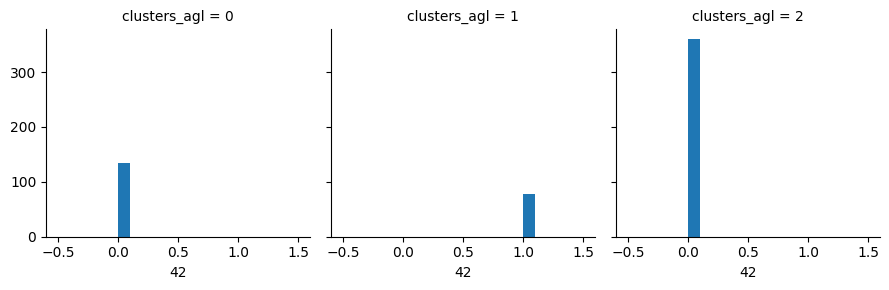

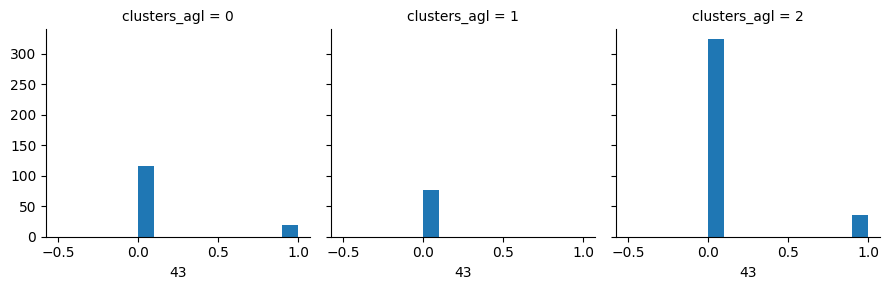

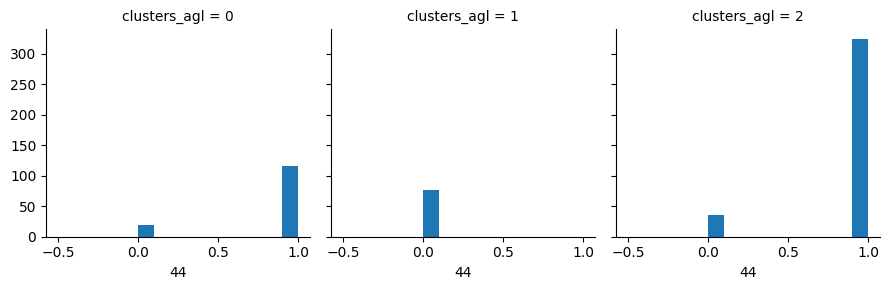

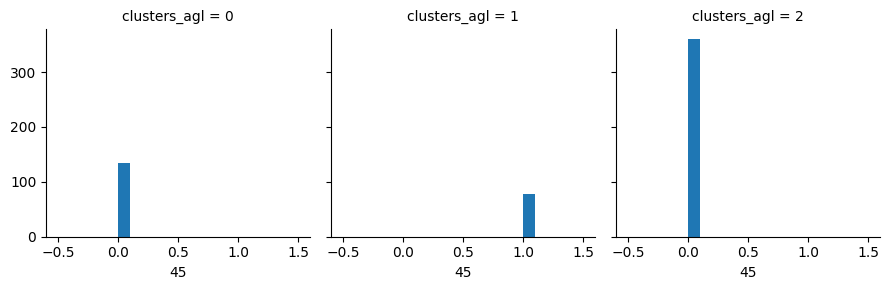

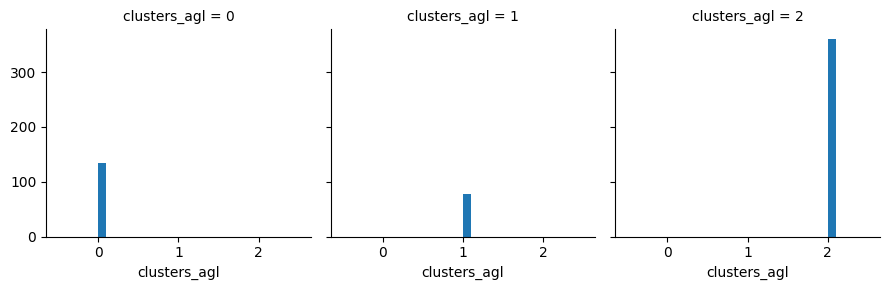

In [135]:
# cluster interpretation
for c in cluster_centers.columns:
    grid= sns.FacetGrid(cluster_centers, col='clusters_agl')
    grid.map(plt.hist, c)

In [136]:
# reference: https://medium.com/more-python-less-problems/principal-component-analysis-and-k-means-clustering-to-visualize-a-high-dimensional-dataset-577b2a7a5fe2

def cluster_visualization(df, columns, labels):
    
    df = df[columns]
    pca = PCA(2)
    pca.fit(df)
    X_PCA = pca.transform(df)
    X_PCA.shape
    print(pca.explained_variance_ratio_)    
    
    x, y = X_PCA[:, 0], X_PCA[:, 1]

    colors = {0: 'red'
              ,1: 'blue'
              ,2: 'green'
              ,3: 'yellow'
              ,4: 'orange'
#               ,5:'purple'
             }

    names = {0: 'Cluster 1'
             ,1: 'Cluster 2' 
             ,2: 'Cluster 3'
             ,3: 'Cluster 4'
             ,4: 'Cluster 5'
            }

    df = pd.DataFrame({'x': x, 'y':y, 'label':labels})
    groups = df.groupby('label')

    fig, ax = plt.subplots(figsize=(20, 13)) 

    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
                color=colors[name],label=names[name], mec='none')
        ax.set_aspect('auto')
        ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
        ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')

    ax.legend()
    ax.set_title("Respondents Segmentation based on their demographics, hospital utilisation & health insurance")
    plt.show()


[0.17054502 0.11828659]


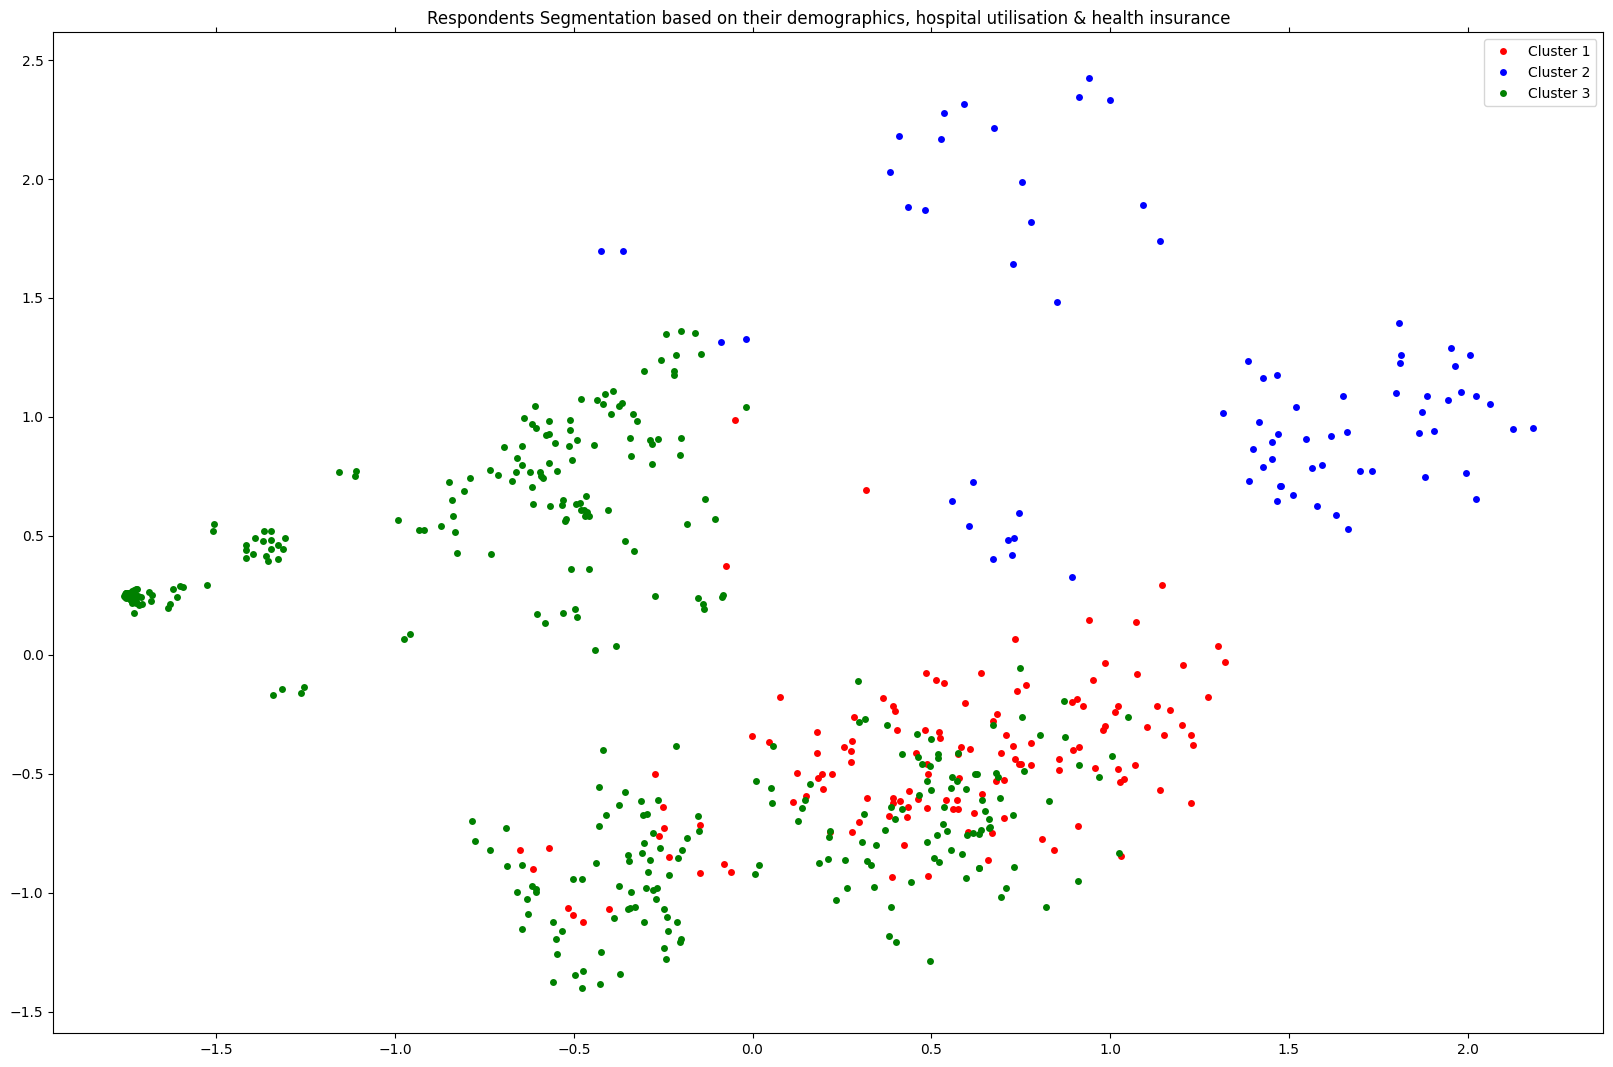

In [137]:
cluster_visualization(cluster_centers, columns = cluster_centers.columns[:-1], labels = cluster_centers["clusters_agl"])

In [138]:
cluster_centers = cluster_centers.reset_index()[["index", "clusters_agl"]].rename(columns = {"index":"clusters_aff"})

In [139]:
cluster_centers

,clusters_aff,clusters_agl
0,0,2
1,1,0
2,2,2
3,3,2
4,4,2
...,...,...
567,567,2
568,568,2
569,569,2
570,570,0


In [141]:
df_dum = df_dum.drop("kproto_cluster_label", axis = 1)

KeyError: "['kproto_cluster_label'] not found in axis"

In [143]:
len(clustering_aff.labels_)

14997

In [145]:
df_dum["clusters_aff"] = clustering_aff.labels_

In [148]:
df_aff = df_dum.merge(cluster_centers, on = ["clusters_aff"])

In [149]:
df_aff

,RIAGENDR,RIDAGEMN,DMDBORN4,SIALANG,SIAPROXY,SIAINTRP,DMDYRUSZ,DMDEDUC2,INDFMPIR,HIQ011,HIQ032A,HIQ032B,HIQ032C,HIQ032D,HIQ032E,HIQ032H,HIQ032I,HUQ010,HUQ071,HUQ090,HUQ051,RIDRETH3_1,RIDRETH3_2,RIDRETH3_3,RIDRETH3_4,RIDRETH3_6,RIDRETH3_7,RIDRETH1_1,RIDRETH1_2,RIDRETH1_3,RIDRETH1_4,RIDRETH1_5,DMDMARTZ_1,DMDMARTZ_2,DMDMARTZ_3,DMDMARTZ_4,RIDEXPRG_1,RIDEXPRG_2,RIDEXPRG_3,RIDEXPRG_4,HIQ270_1,HIQ270_2,HIQ270_3,HIQ210_1,HIQ210_2,HIQ210_3,clusters_aff,clusters_agl
0,0,0.025000,0,0,1,0,1.0,1.0,0.932,1,0,0,0,0,0,0,0,0.00,0,0,0.125,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,195,2
1,0,0.087500,0,0,1,0,1.0,1.0,0.956,1,0,0,0,0,0,0,0,0.25,0,0,0.125,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,195,2
2,0,0.007292,0,0,1,0,1.0,1.0,0.984,1,0,0,0,0,0,0,0,0.25,0,0,0.750,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,195,2
3,0,0.087500,0,0,1,0,1.0,1.0,1.000,1,0,0,0,0,0,0,0,0.00,0,0,0.250,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,195,2
4,0,0.037500,0,0,1,0,1.0,1.0,0.834,1,0,0,0,0,0,0,0,0.00,0,0,0.250,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,195,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14992,1,0.137500,0,0,1,0,1.0,1.0,0.894,1,0,0,0,0,0,0,0,0.00,0,0,0.250,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,420,2
14993,1,0.125000,0,0,1,0,1.0,1.0,0.932,1,0,0,0,0,0,0,0,0.00,0,0,0.250,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,420,2
14994,1,0.075000,0,0,1,0,1.0,1.0,0.994,1,0,0,0,0,0,0,0,0.00,0,0,0.250,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,486,2
14995,1,0.075000,0,0,1,0,1.0,1.0,0.862,1,0,0,0,0,0,0,0,0.00,0,0,0.250,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,508,2


In [150]:
# reference: https://medium.com/more-python-less-problems/principal-component-analysis-and-k-means-clustering-to-visualize-a-high-dimensional-dataset-577b2a7a5fe2

def cluster_visualization(df, columns, labels):
    
    df = df[columns]
    pca = PCA(2)
    pca.fit(df)
    X_PCA = pca.transform(df)
    X_PCA.shape
    print(pca.explained_variance_ratio_)    
    
    x, y = X_PCA[:, 0], X_PCA[:, 1]

    colors = {0: 'red'
              ,1: 'blue'
              ,2: 'green'
              ,3: 'yellow'
              ,4: 'orange'
#               ,5:'purple'
             }

    names = {0: 'Cluster 1'
             ,1: 'Cluster 2' 
             ,2: 'Cluster 3'
             ,3: 'Cluster 4'
             ,4: 'Cluster 5'
            }

    df = pd.DataFrame({'x': x, 'y':y, 'label':labels})
    groups = df.groupby('label')

    fig, ax = plt.subplots(figsize=(20, 13)) 

    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
                color=colors[name],label=names[name], mec='none')
        ax.set_aspect('auto')
        ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
        ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')

    ax.legend()
    ax.set_title("Respondents Segmentation based on their demographics, hospital utilisation & health insurance")
    plt.show()


[0.15800095 0.13639769]


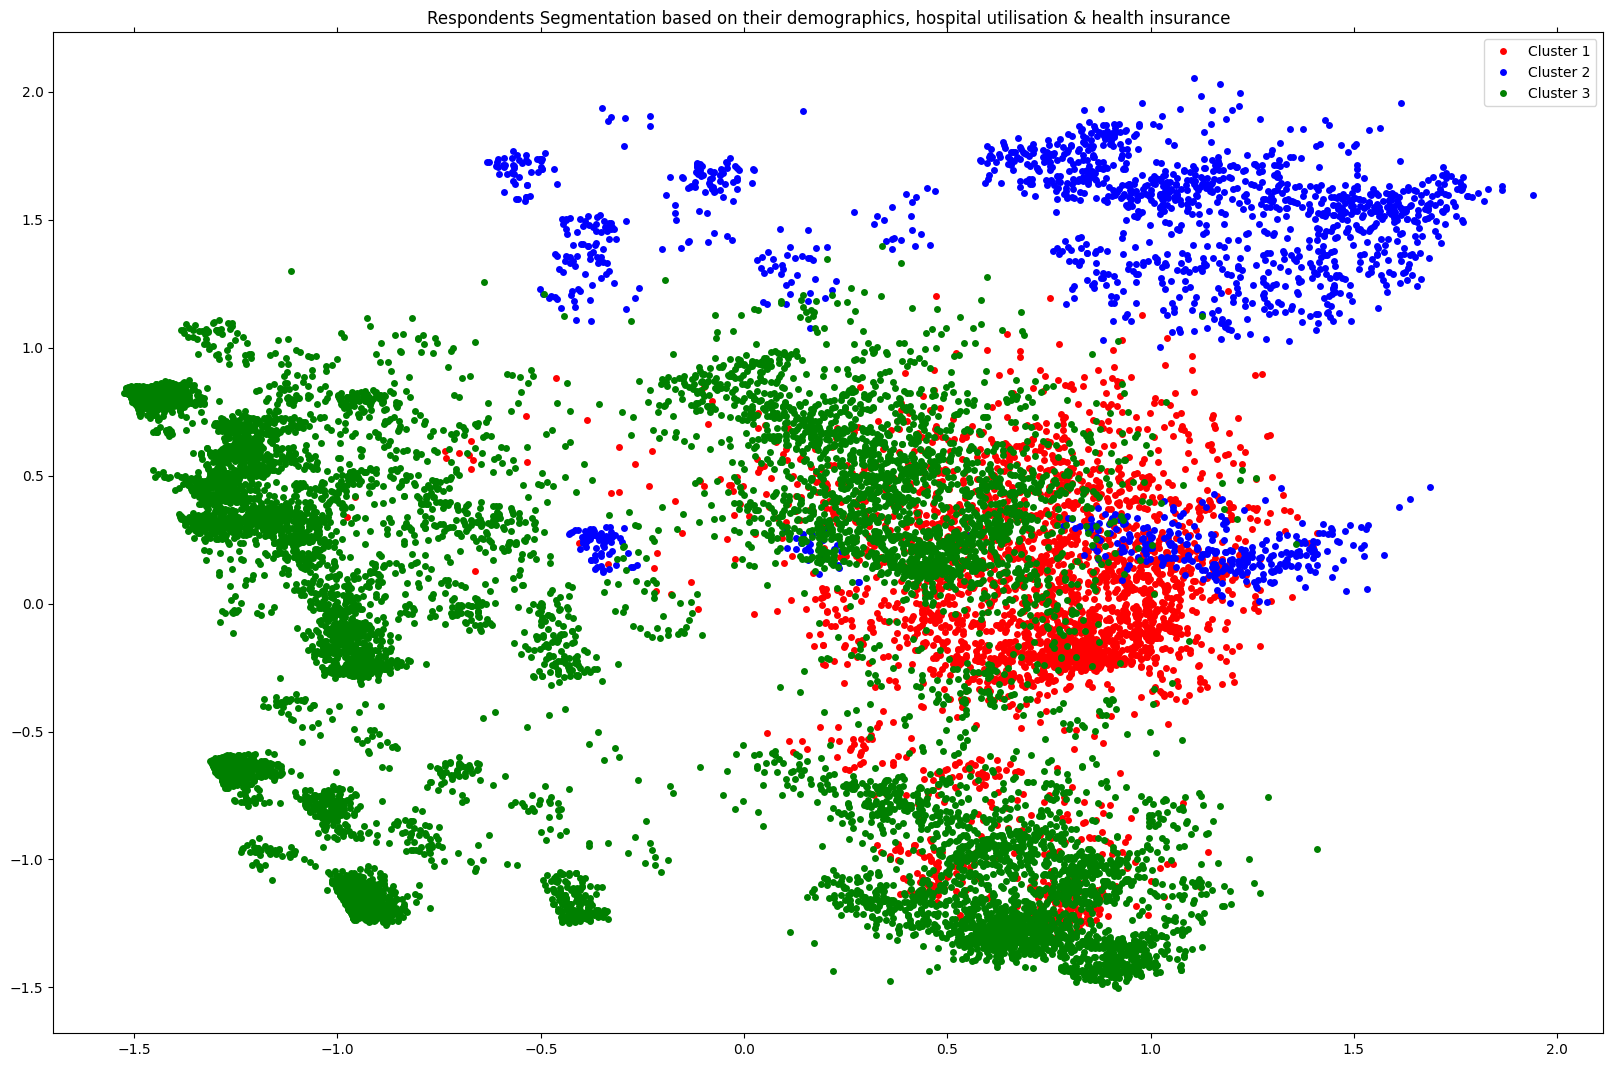

In [155]:
cluster_visualization(df_aff, columns = df_aff.columns[:-2], labels = df_aff["clusters_agl"])

In [157]:
df["clusters_aff"] = df_aff["clusters_agl"]

/home/students/risaac/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


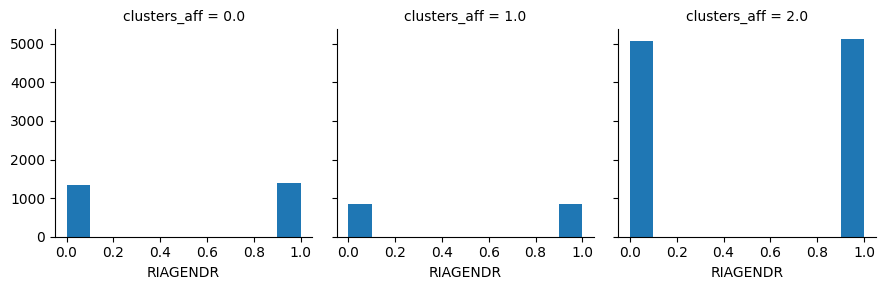

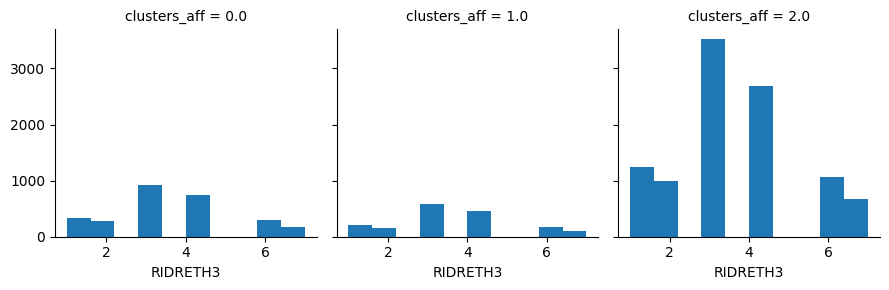

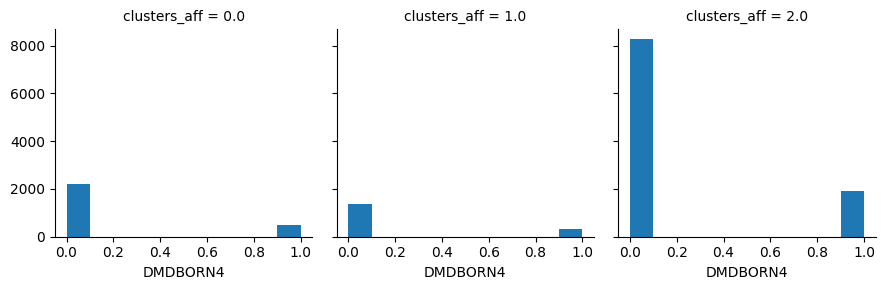

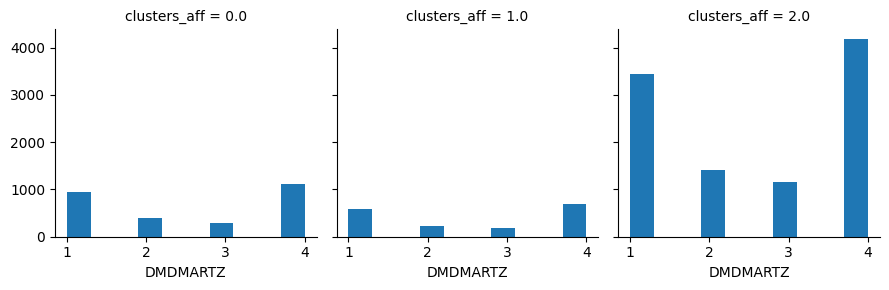

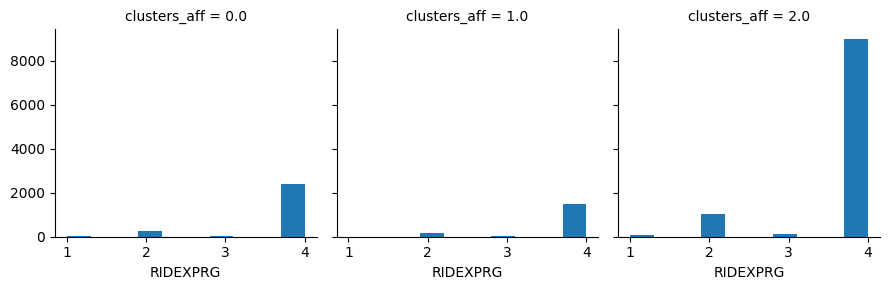

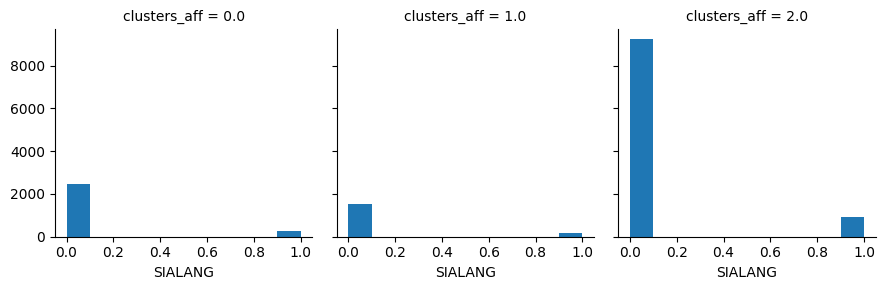

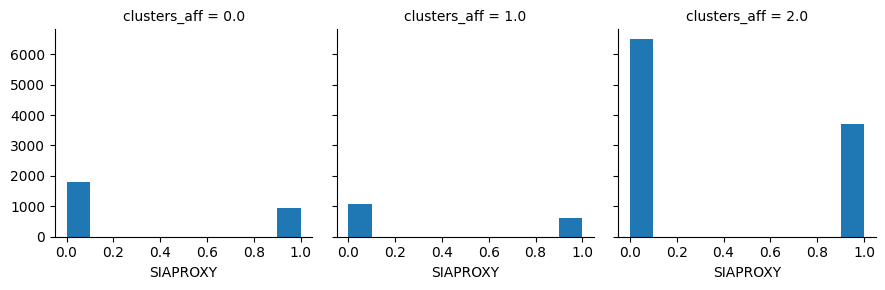

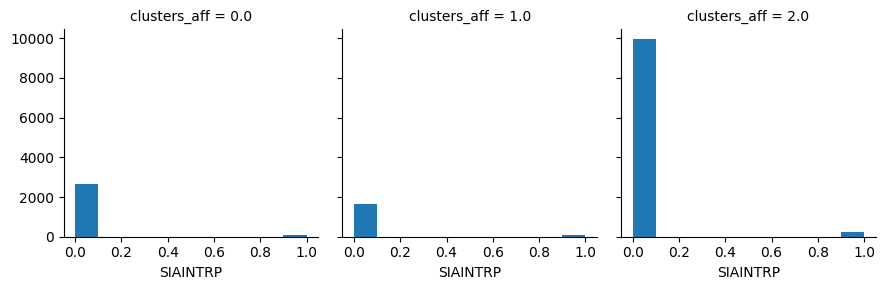

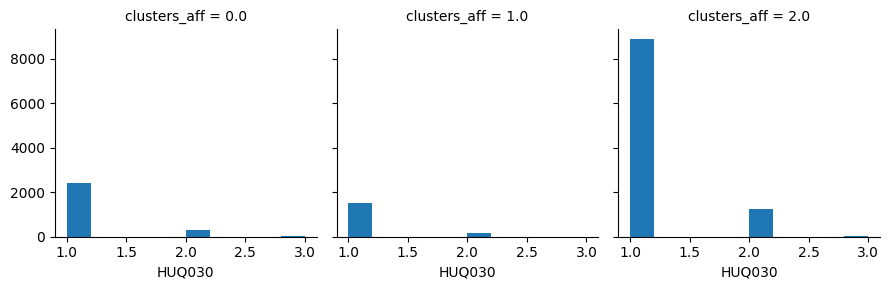

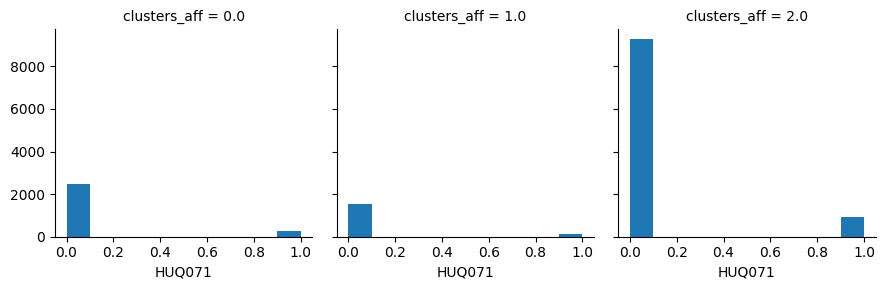

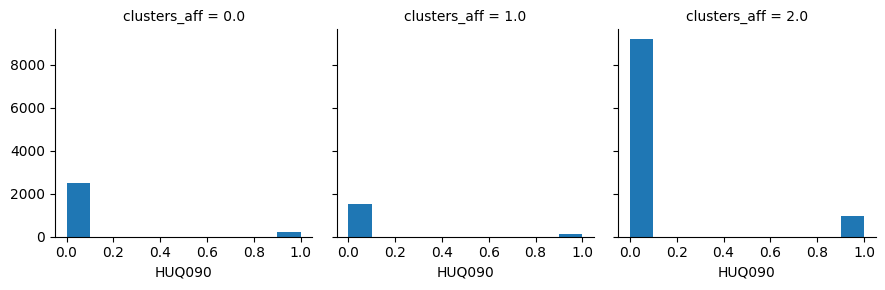

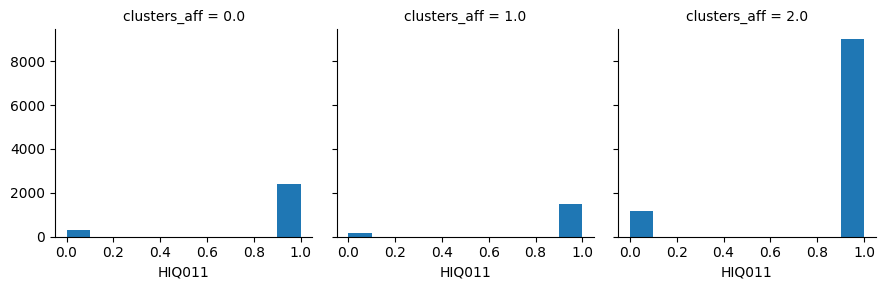

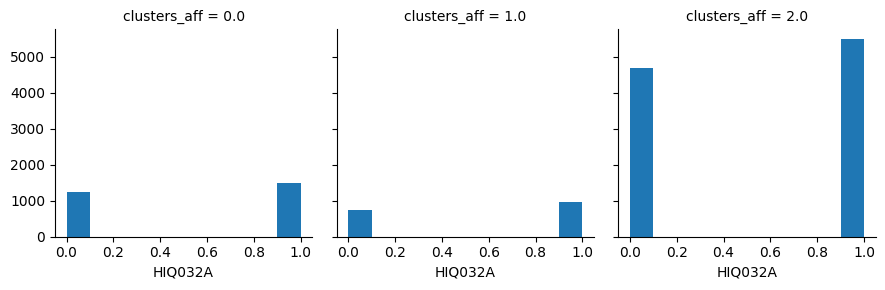

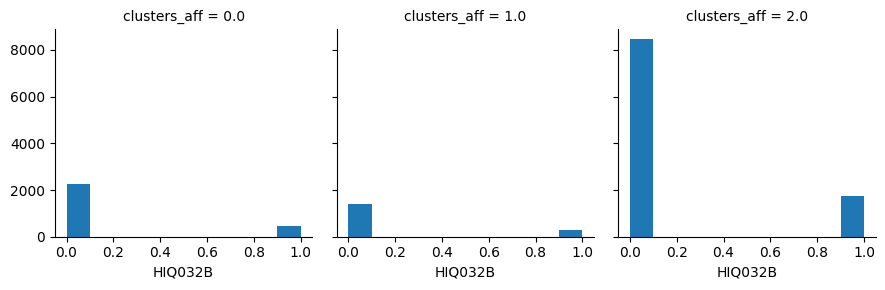

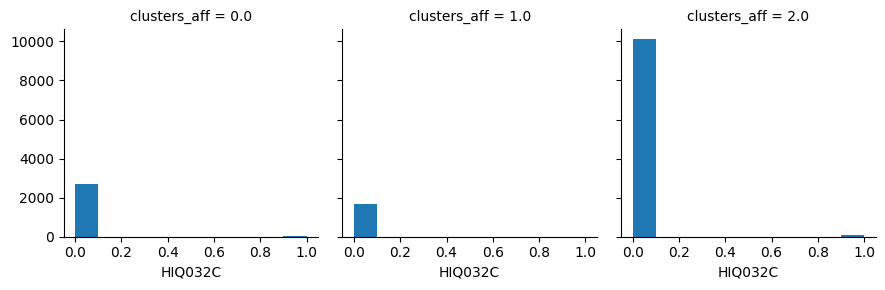

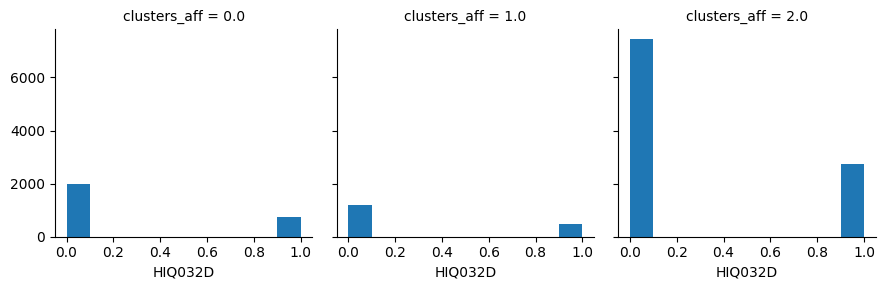

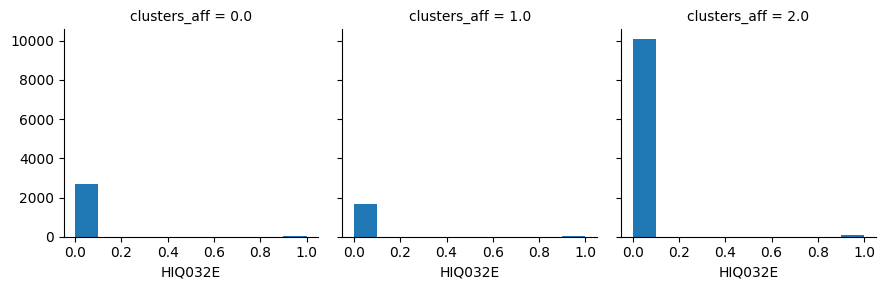

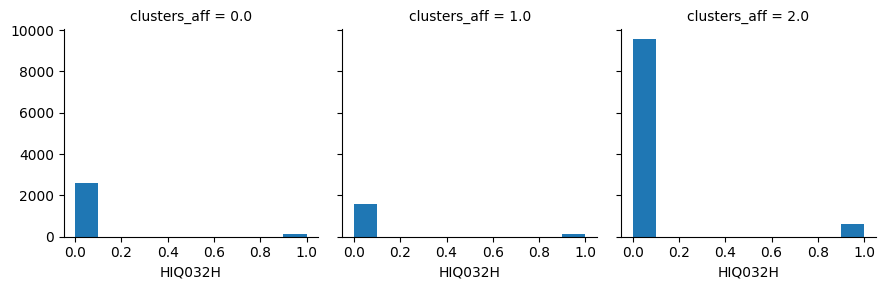

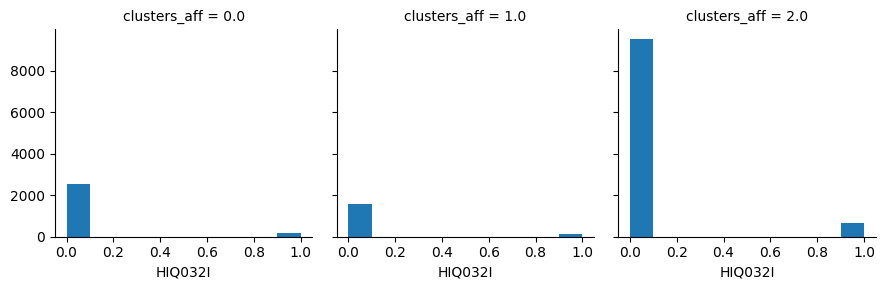

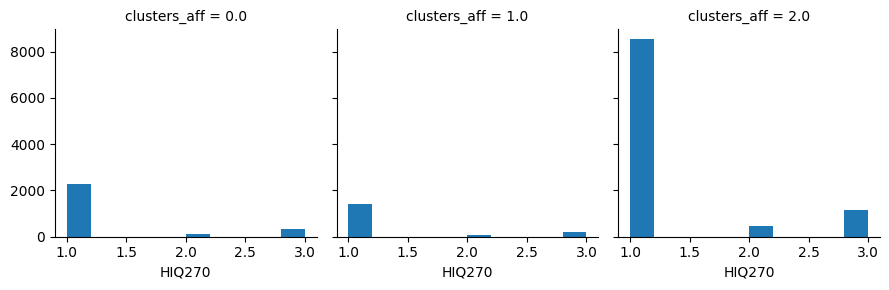

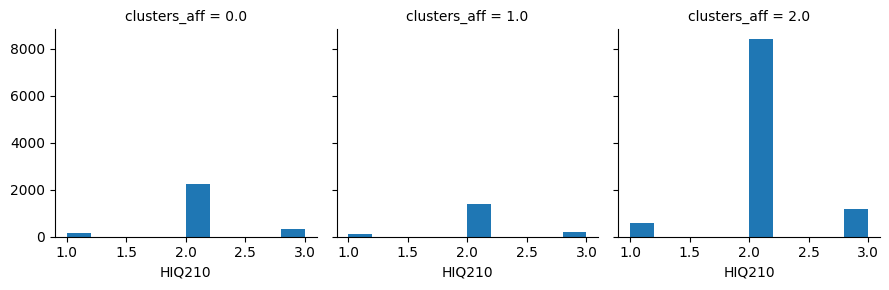

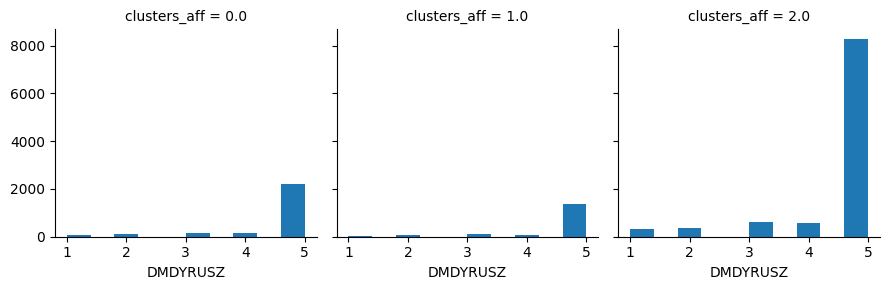

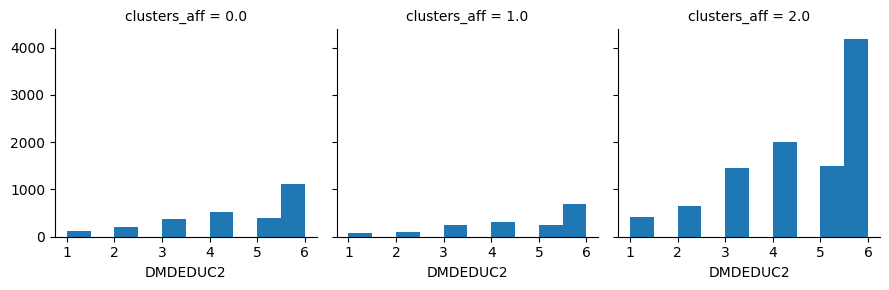

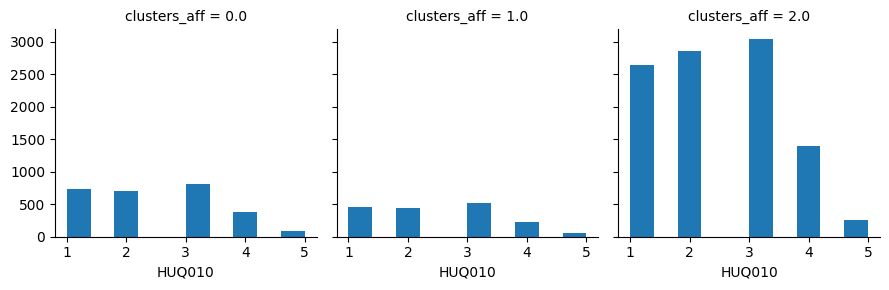

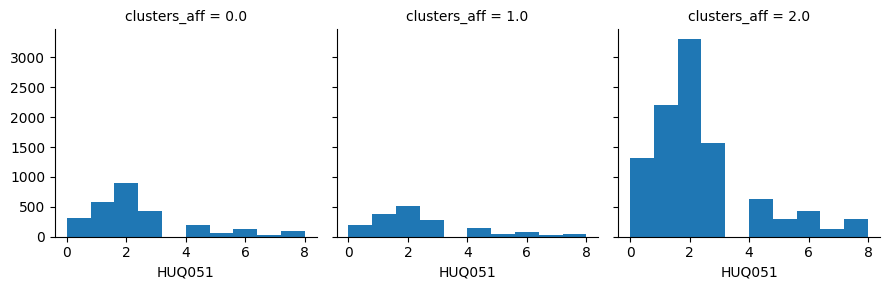

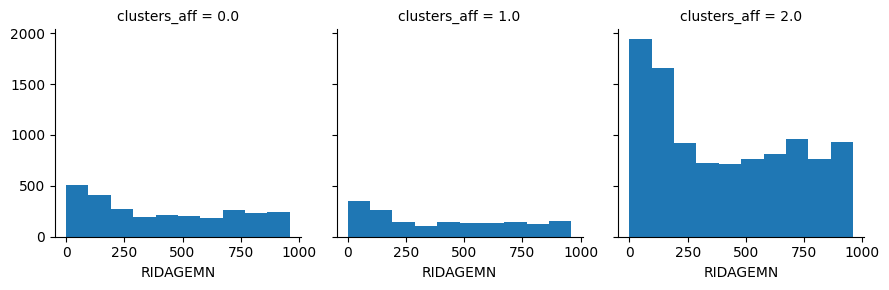

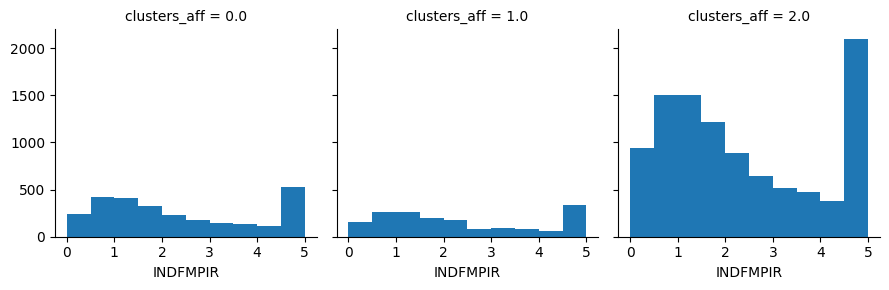

In [161]:
# cluster interpretation
for c in df[nominal_cols + ordinal_cols + numeric_cols ]:
    grid= sns.FacetGrid(df[nominal_cols + ordinal_cols + numeric_cols + ['clusters_aff']], col='clusters_aff')
    grid.map(plt.hist, c)

In [173]:
df[df["clusters_aff"] == 0].describe()

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,DMDBORN4,DMDYRUSZ,DMDEDUC2,DMDMARTZ,RIDEXPRG,SIALANG,SIAPROXY,SIAINTRP,INDFMPIR,HUQ010,HUQ030,HUQ051,HUQ071,HUQ090,HIQ011,HIQ032A,HIQ032B,HIQ032C,HIQ032D,HIQ032E,HIQ032H,HIQ032I,HIQ270,HIQ210,clusters_aff
count,2731.00000,2731.0,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.0
mean,118166.09740,66.0,1.923471,0.506408,34.064079,409.103991,3.272062,3.509337,0.185280,4.586598,4.536434,2.570853,3.761992,0.094105,0.345661,0.025998,2.387733,2.404980,1.123032,2.380447,0.098865,0.085317,0.879531,0.544489,0.170267,0.005492,0.270963,0.013914,0.054559,0.063347,1.283779,2.060784,0.0
std,4404.86581,0.0,0.265891,0.500050,25.364983,303.939088,1.212701,1.613191,0.388596,0.977825,1.522135,1.320595,0.655016,0.292028,0.475670,0.159158,1.625078,1.120258,0.341652,1.864230,0.298535,0.279404,0.325568,0.498108,0.375936,0.073921,0.444538,0.117157,0.227159,0.243630,0.666045,0.419275,0.0
min,109386.00000,66.0,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0
25%,114055.50000,66.0,2.000000,0.000000,11.000000,132.000000,3.000000,3.000000,0.000000,5.000000,3.000000,1.000000,4.000000,0.000000,0.000000,0.000000,1.010000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.0
50%,118531.00000,66.0,2.000000,1.000000,31.000000,372.000000,3.000000,3.000000,0.000000,5.000000,5.000000,3.000000,4.000000,0.000000,0.000000,0.000000,1.950000,2.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.0
75%,122294.50000,66.0,2.000000,1.000000,57.000000,684.000000,4.000000,4.000000,0.000000,5.000000,6.000000,4.000000,4.000000,0.000000,1.000000,0.000000,3.880000,3.000000,1.000000,3.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.0
max,124369.00000,66.0,2.000000,1.000000,80.000000,960.000000,5.000000,7.000000,1.000000,5.000000,6.000000,4.000000,4.000000,1.000000,1.000000,1.000000,5.000000,5.000000,3.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,0.0


In [174]:
df[df["clusters_aff"] == 1].describe()

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,DMDBORN4,DMDYRUSZ,DMDEDUC2,DMDMARTZ,RIDEXPRG,SIALANG,SIAPROXY,SIAINTRP,INDFMPIR,HUQ010,HUQ030,HUQ051,HUQ071,HUQ090,HIQ011,HIQ032A,HIQ032B,HIQ032C,HIQ032D,HIQ032E,HIQ032H,HIQ032I,HIQ270,HIQ210,clusters_aff
count,1692.000000,1692.0,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.0
mean,117955.976950,66.0,1.912530,0.505910,33.118203,397.799645,3.258274,3.479905,0.181442,4.589243,4.544326,2.592790,3.745272,0.095154,0.371749,0.037234,2.367996,2.393026,1.115839,2.336288,0.085106,0.088652,0.887116,0.563830,0.159574,0.005319,0.289598,0.015366,0.065012,0.067376,1.266548,2.044326,1.0
std,3998.188232,0.0,0.282607,0.500113,25.357974,303.807715,1.205677,1.586891,0.385498,0.978638,1.534480,1.325373,0.670054,0.293514,0.483415,0.189391,1.631125,1.103094,0.332807,1.808981,0.279122,0.284326,0.316545,0.496056,0.366319,0.072760,0.453710,0.123042,0.246620,0.250746,0.646506,0.419565,0.0
min,110149.000000,66.0,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.0
25%,114602.750000,66.0,2.000000,0.000000,9.000000,108.000000,3.000000,3.000000,0.000000,5.000000,3.000000,1.000000,4.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1.0
50%,118416.500000,66.0,2.000000,1.000000,31.000000,372.000000,3.000000,3.000000,0.000000,5.000000,5.000000,3.000000,4.000000,0.000000,0.000000,0.000000,1.890000,2.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1.0
75%,121629.250000,66.0,2.000000,1.000000,55.000000,660.000000,4.000000,4.000000,0.000000,5.000000,6.000000,4.000000,4.000000,0.000000,1.000000,0.000000,3.850000,3.000000,1.000000,3.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1.0
max,124261.000000,66.0,2.000000,1.000000,80.000000,960.000000,5.000000,7.000000,1.000000,5.000000,6.000000,4.000000,4.000000,1.000000,1.000000,1.000000,5.000000,5.000000,3.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,1.0


In [175]:
df[df["clusters_aff"] == 2].describe()

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,DMDBORN4,DMDYRUSZ,DMDEDUC2,DMDMARTZ,RIDEXPRG,SIALANG,SIAPROXY,SIAINTRP,INDFMPIR,HUQ010,HUQ030,HUQ051,HUQ071,HUQ090,HIQ011,HIQ032A,HIQ032B,HIQ032C,HIQ032D,HIQ032E,HIQ032H,HIQ032I,HIQ270,HIQ210,clusters_aff
count,10182.000000,10182.0,10182.000000,10182.000000,10182.000000,10182.000000,10182.000000,10182.000000,10182.000000,10182.000000,10182.000000,10182.000000,10182.000000,10182.000000,10182.000000,10182.000000,10182.000000,10182.000000,10182.000000,10182.000000,10182.000000,10182.000000,10182.000000,10182.000000,10182.000000,10182.000000,10182.000000,10182.000000,10182.000000,10182.000000,10182.000000,10182.000000,10182.0
mean,116315.621980,66.0,1.919073,0.502455,33.692988,404.651444,3.263897,3.500295,0.187979,4.578275,4.574838,2.597329,3.771558,0.092713,0.362404,0.023276,2.412835,2.387056,1.133176,2.300530,0.089275,0.096739,0.883716,0.539187,0.169613,0.006777,0.269495,0.010116,0.061481,0.065508,1.276370,2.055687,2.0
std,4313.774507,0.0,0.272737,0.500019,25.389492,304.238028,1.208940,1.610955,0.390714,0.991721,1.489856,1.317605,0.640499,0.290044,0.480718,0.150787,1.641976,1.085103,0.352550,1.832768,0.285155,0.295617,0.320580,0.498487,0.375311,0.082045,0.443719,0.100073,0.240222,0.247432,0.655029,0.412627,0.0
min,109263.000000,66.0,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.0
25%,112563.250000,66.0,2.000000,0.000000,10.000000,120.000000,3.000000,3.000000,0.000000,5.000000,4.000000,1.000000,4.000000,0.000000,0.000000,0.000000,1.020000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,2.0
50%,116316.500000,66.0,2.000000,1.000000,30.000000,360.000000,3.000000,3.000000,0.000000,5.000000,5.000000,3.000000,4.000000,0.000000,0.000000,0.000000,1.960000,2.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,2.0
75%,119896.750000,66.0,2.000000,1.000000,56.000000,672.000000,4.000000,4.000000,0.000000,5.000000,6.000000,4.000000,4.000000,0.000000,1.000000,0.000000,3.920000,3.000000,1.000000,3.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,2.0
max,124416.000000,66.0,2.000000,1.000000,80.000000,960.000000,5.000000,7.000000,1.000000,5.000000,6.000000,4.000000,4.000000,1.000000,1.000000,1.000000,5.000000,5.000000,3.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,2.0


In [176]:
df["clusters_aff"].unique()

array([ 2.,  0.,  1., nan])

In [165]:
score = silhouette_score(df_aff.drop("clusters_aff", axis = 1), df_aff["clusters_agl"], metric='cosine')

In [166]:
score

0.4301252949501153